### Table of Contents
* [Loading dataset and libraries](#chapter0)
* [Functions for automation](#chapter1)
* [Tests](#chapter2)
     * [Kmeans clustering](#section_1_1)
     * [PCA](#section_1_2)
     * [DBSCAN clustering](#section_1_3)
     * [Hierarchical clustering](#section_1_4)
* [Results](#chapter3)

# Loading dataset and libraries <a class="anchor" id='chapter0'></a>

In [292]:
#load datas

import os

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn import decomposition
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import plotly.express as px

import scipy.cluster.hierarchy as shc

working_directory = os.getcwd()
print(working_directory)

/Users/jeaneudesdesgraviers/Downloads


In [294]:
df_final = pd.read_csv('df_modelisation.csv')
df_final.columns

Index(['customer_unique_id', 'review_score', 'Recency', 'Frequency',
       'Monetary', 'R', 'F', 'M', 'RFM_Segment', 'RFM_Score', 'Title',
       'time_delivery', 'payment_installments', 'Item_per_order',
       'construction', 'electronics', 'fashion', 'food_drink', 'furniture',
       'gifts', 'health_beauty', 'home', 'misc', 'sports_leisure', 'supplies',
       'Freight_ratio', 'haversine_distance'],
      dtype='object')

# Functions for automation <a class="anchor" id='chapter1'></a>

In [15]:
#Automatization for clustering research optimization

def Find_k_with_elbow_and_silhouette(df, features):
    
    # Compute a kmeans over the selected datas and perform clustering over it,
    # Plot Elbow graph,
    # Return Silhouette and Calinsky Score for different amount of cluster.
    
    df_log = np.log(df[features])

    scaler = StandardScaler()
    scaler.fit(df_log)
    df_ssed = scaler.transform(df_log)

    max_cluster = 10
    clusters = range(1,max_cluster)
    intra_sum_of_square_list = []
    for i in clusters:
        km = KMeans(n_clusters=i,init="k-means++",n_init=10,max_iter=300, random_state = 1)
        km.fit(df_ssed)
        intra_sum_of_square_list.append(km.inertia_)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Elbow Method")
    ax.set_xlabel("Number of Cluster")
    ax.set_ylabel("Intra sum of distances(WCSS)")
    plt.plot(clusters,intra_sum_of_square_list)

    for i in range(3,8):
        labels=KMeans(n_clusters=i, random_state=1, n_init = 'auto').fit(df_ssed).labels_
        print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(df_ssed,labels,metric="euclidean",random_state=1)))

In [26]:
def Find_k_with_elbow_and_silhouette_minmaxScaled(df, features):
    
    # Same as Find_k_with_elbow_and_silhouette() but with MinMax scaling difference.

    scaler = MinMaxScaler()
    scaler.fit(df[features])
    df_mmsed = scaler.transform(df[features])
    
    max_cluster = 10
    clusters = range(1,max_cluster)
    intra_sum_of_square_list = []
    for i in clusters:
        km = KMeans(n_clusters=i,init="k-means++",n_init=10,max_iter=300, random_state = 1)
        km.fit(df_mmsed)
        intra_sum_of_square_list.append(km.inertia_)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Elbow Method")
    ax.set_xlabel("Number of Cluster")
    ax.set_ylabel("Intra sum of distances(WCSS)")
    plt.plot(clusters,intra_sum_of_square_list)

    for i in range(3,8):
        labels=KMeans(n_clusters=i, random_state=1, n_init = 'auto').fit(df_mmsed).labels_
        print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(df_mmsed,labels,metric="euclidean")))
        print ("Calinski-Harabasz score for k(clusters) = "+str(i)+" is "
           +str(metrics.calinski_harabasz_score(df_mmsed,labels)))
        print("-" * 100)

In [143]:
def Silhouette_plot(df, k, features):
    
    # Compute a kmeans over the selected datas and perform clustering over it, 
    # Then make first segmentation visualization of silhouette plot with best params 'k'.

    scaler = MinMaxScaler()
    scaler.fit(df[features])
    df_mmsed = scaler.transform(df[features])

    kmeans = KMeans(n_clusters=k,init="k-means++",n_init=10,max_iter=300, random_state = 1)

    #compute k-means clustering on preprocessed data
    kmeans.fit(df_mmsed)

    #Extract cluster label from labels_ attribute
    cluster_labels = kmeans.labels_

    #Calculate the average of silhouette scores
    silhouette_avg = silhouette_score(df_mmsed,cluster_labels)

    #Calculate the silhouette score for each data
    each_silhouette_score = silhouette_samples(df_mmsed,cluster_labels,metric="euclidean")
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    y_lower =10
    for i in range(k):
        ith_cluster_silhouette_values = each_silhouette_score[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,alpha=0.3)

        #label the silhouse plots with their cluster numbers at the middle
        ax.text(-0.05,y_lower + 0.5 * size_cluster_i,str(i))

        #compute the new y_lower for next plot
        y_lower = y_upper +10 

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette score")
    ax.set_ylabel("Cluster label")

    #the vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg,color="red",linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1])

In [249]:
def compute_kmeans_df_and_plot(df, k, features):
    
    # Compute a kmeans over the selected datas and perform clustering over it, 
    # then return dataframe of clusters mean values and a pie chart of the distribution within clusters.
    
    scaler = MinMaxScaler()
    scaler.fit(df[features])
    df_mmsed = scaler.transform(df[features])

    kmeans = KMeans(n_clusters=k,init="k-means++",n_init=10,max_iter=300, random_state = 1)

    #compute k-means clustering on preprocessed data
    kmeans.fit(df_mmsed)

    #Extract cluster label from labels_ attribute
    cluster_labels = kmeans.labels_

    #create a cluster label column in the original dataframe
    df_k = df.assign(Cluster = cluster_labels)

    #Calculate average values and size for each cluster
    #cols = [col for col in df.columns]
    dic_agg = {}
    for feature in features :
        dic_agg[feature] = 'mean'
    df_grouped = df_k.groupby(['Cluster']).agg(dic_agg)
    display(df_grouped)
    colors = ['#ff9999','#66b3ff','#79ff91','#ffcc99','#BA55D3']
    #df_k.groupby(['Cluster']).agg(dic_agg).plot.bar(figsize=(5, 2), color = colors).legend(bbox_to_anchor=(1, 0.8))
    #plt.title("Moyenne des attributs par cluster")
    Clust_sizes = df_k.groupby('Cluster').size()
    Clust_sizes.columns = ["Size"]
    plt.pie(Clust_sizes,labels=df_k['Cluster'].unique(), 
            colors = ['#ff9999','#66b3ff','#79ff91','#ffcc99','#BA55D3'],
            autopct=lambda p : '{:,.0f} \n ({:.2f}%)'.format(p * sum(Clust_sizes)/100,p))
    plt.show()
    

In [250]:
def plot_radars(data, group):
    
    # Compute a kmeans over the selected datas and perform clustering over it,
    # Plot a scaled radar chart to visualize clustering groups.

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()     

In [251]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    # Take datas to visualize Principal component Analysis correlation circles.
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

# Tests <a class="anchor" id='chapter2'></a>

## Kmeans Clustering <a class="anchor" id='section_1_1' ></a>

In [5]:
#First try on RFM attributes

Silhouette score for k(clusters) = 3 is 0.39120906693369745
calinski harabasz score for k(clusters) = 3 is 51653.771060703126
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.42827894485342805
calinski harabasz score for k(clusters) = 4 is 54361.221243899054
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.480048305434785
calinski harabasz score for k(clusters) = 5 is 52769.06118475871
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.5111414563364016
calinski harabasz score for k(clusters) = 6 is 49922.03909255253
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.5902005340666397
calinski harabasz score for k(clusters

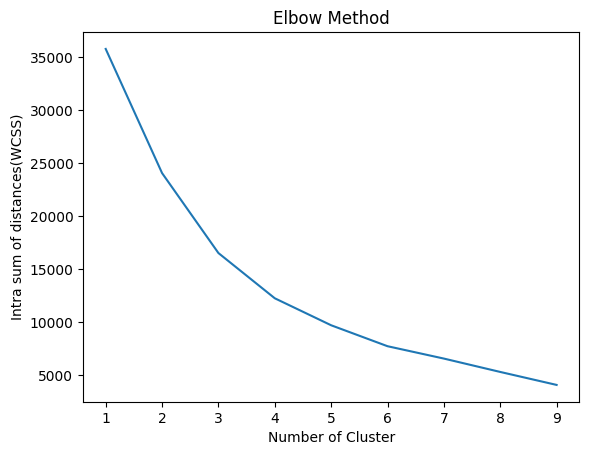

In [24]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['R','F','M'])

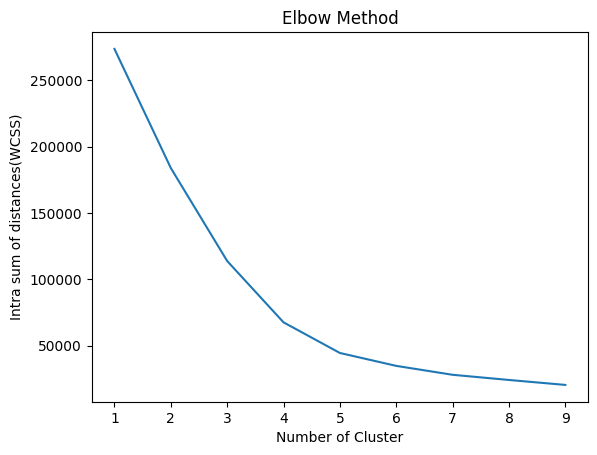

In [6]:
#Find out what number of cluster for the features RFM with elbow then silhouette-Calinsky and graph visualization

In [7]:
#Best number of cluster choice seems to be between 3 and 5

In [9]:
# The Silhouette Coefficient is calculated using the mean intra-cluster distance. 
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# In this case we can see clusters separation is not optimal

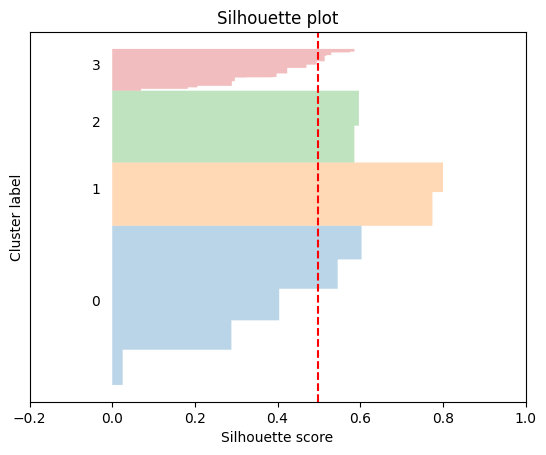

In [12]:
Silhouette_plot(df_final, 4, ['R','F','M'])

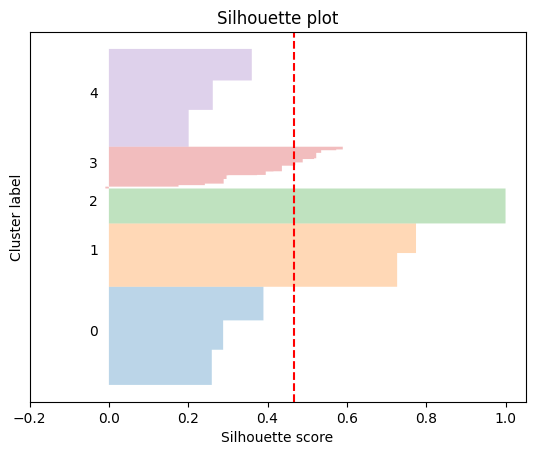

In [13]:
Silhouette_plot(df_final, 5, ['R','F','M'])

In [ ]:
# There is a cluster which is below average silhouette score which means that 4 and 5 are not a good cluster values for the given data.
# Though we will use 3 as the cluster value

R         F         M
Cluster                              
0        2.000921  1.063821  1.000000
1        1.493687  1.256704  2.499442
2        3.000000  1.248817  2.493244

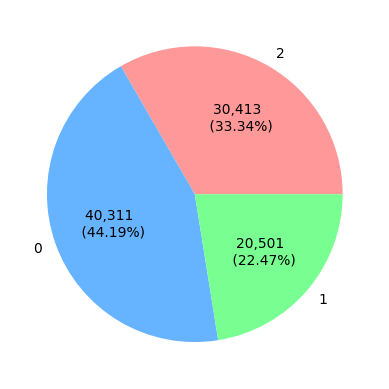

Cluster
0    30413
1    40311
2    20501
dtype: int64


In [214]:
compute_kmeans_df_and_plot(df_final, 3, ['R','F','M'])

In [25]:
# Analyze first segmentation

# group 0 : recent purchase([70;220] days), one purchase, medium wallet(average 90)
# group 1 : Old purchase(average 400 days), one purchase, medium small wallet([35;90])
# group 2 : average time purchase(around 220 days), 2 or more purchases, medium high wallet([90;420])

# This segmentation will serve as baseline on which we will change features in order to have a more addapted clustering.

Silhouette score for k(clusters) = 3 is 0.31267070975141625
Silhouette score for k(clusters) = 4 is 0.3729217259091851
Silhouette score for k(clusters) = 5 is 0.47997544675853904
Silhouette score for k(clusters) = 6 is 0.5377531189118941
Silhouette score for k(clusters) = 7 is 0.5416432556109902


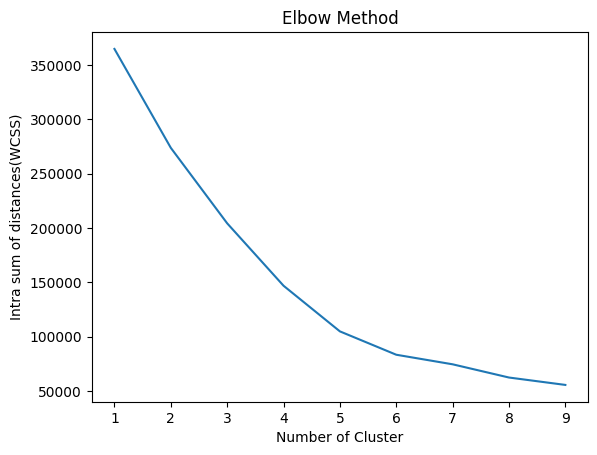

In [22]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M', 'review_score'])

Silhouette score for k(clusters) = 3 is 0.2667471270803658
Silhouette score for k(clusters) = 4 is 0.2892059220747108
Silhouette score for k(clusters) = 5 is 0.3293650522665427
Silhouette score for k(clusters) = 6 is 0.30526006494246954
Silhouette score for k(clusters) = 7 is 0.33872523072272265


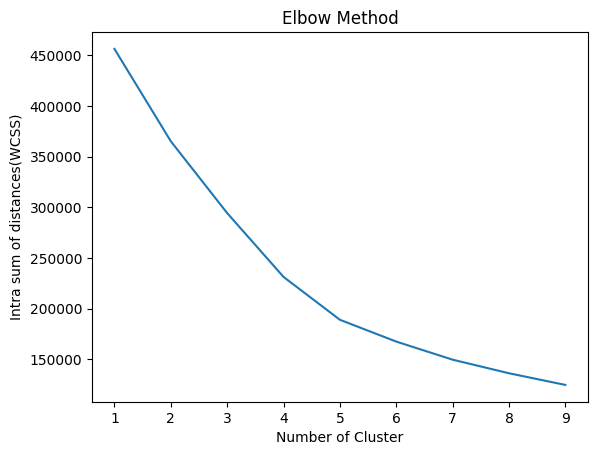

In [23]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M', 'review_score', 'time_delivery'])

Silhouette score for k(clusters) = 3 is 0.32366427897064703
Silhouette score for k(clusters) = 4 is 0.3506295489640636
Silhouette score for k(clusters) = 5 is 0.3511404616584463
Silhouette score for k(clusters) = 6 is 0.34444808652947356
Silhouette score for k(clusters) = 7 is 0.3778759441915024


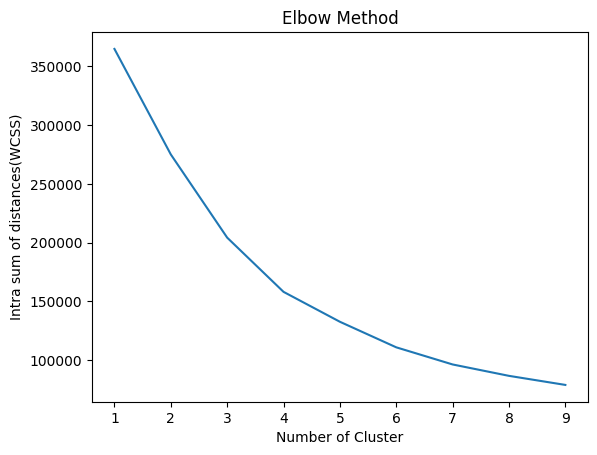

In [24]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M', 'time_delivery'])

Silhouette score for k(clusters) = 3 is 0.4151224913217162
Silhouette score for k(clusters) = 4 is 0.314887235647877
Silhouette score for k(clusters) = 5 is 0.37915191117975344
Silhouette score for k(clusters) = 6 is 0.3396327209317856
Silhouette score for k(clusters) = 7 is 0.34233695041802475


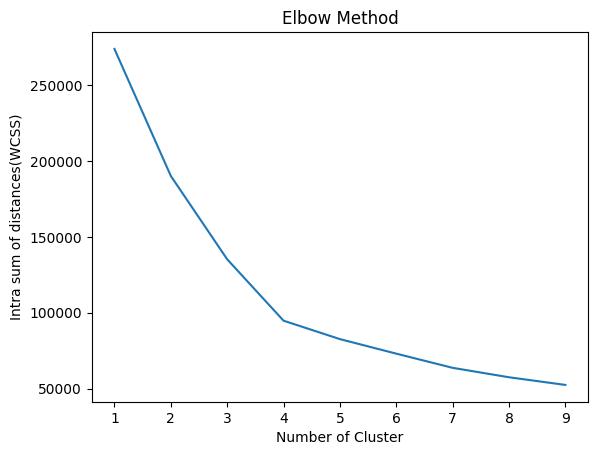

In [25]:
Find_k_with_elbow_and_silhouette(df_final, ['Recency','Frequency','Monetary'])

Silhouette score for k(clusters) = 3 is 0.2452730470650564
Silhouette score for k(clusters) = 4 is 0.31843091480949154
Silhouette score for k(clusters) = 5 is 0.386434013940072
Silhouette score for k(clusters) = 6 is 0.3941900455790188
Silhouette score for k(clusters) = 7 is 0.43516261208638446


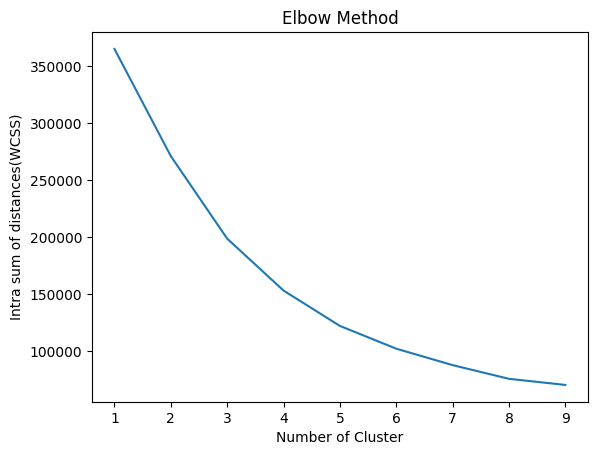

In [31]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','payment_installments'])

Silhouette score for k(clusters) = 3 is 0.21616530497355257
Silhouette score for k(clusters) = 4 is 0.2293257209736153
Silhouette score for k(clusters) = 5 is 0.23752096241188655
Silhouette score for k(clusters) = 6 is 0.24049434291496663
Silhouette score for k(clusters) = 7 is 0.22865790421328563


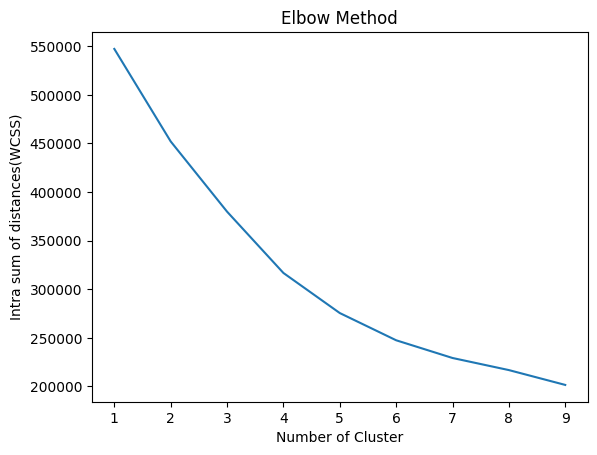

In [32]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','review_score','time_delivery','payment_installments'])

Silhouette score for k(clusters) = 3 is 0.2563459578921306
Silhouette score for k(clusters) = 4 is 0.3650742275990426
Silhouette score for k(clusters) = 5 is 0.3539164447478647
Silhouette score for k(clusters) = 6 is 0.32617154994340586
Silhouette score for k(clusters) = 7 is 0.4096000098399349


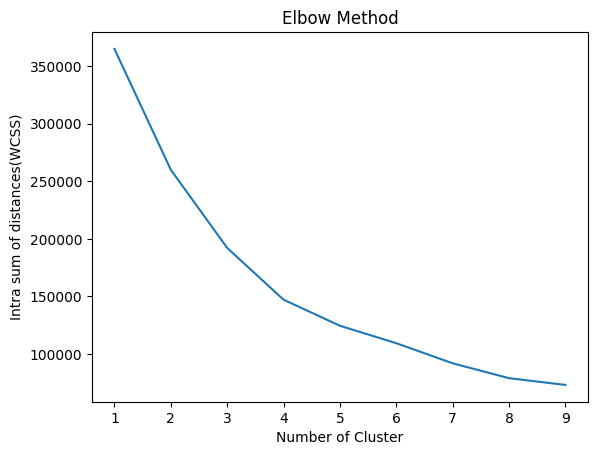

In [33]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','product_qty'])

Silhouette score for k(clusters) = 3 is 0.1797513204532913
Silhouette score for k(clusters) = 4 is 0.17679869006654544
Silhouette score for k(clusters) = 5 is 0.19738322120753737
Silhouette score for k(clusters) = 6 is 0.1848360777539253
Silhouette score for k(clusters) = 7 is 0.19750008792009172


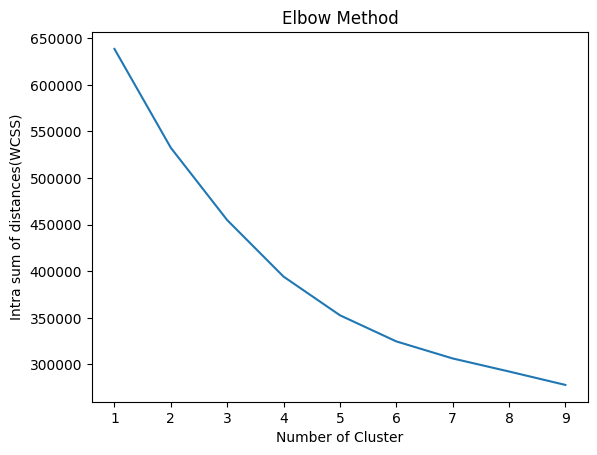

In [34]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','review_score','time_delivery','payment_installments','product_photos_qty'])

Silhouette score for k(clusters) = 3 is 0.15950891019116292
Silhouette score for k(clusters) = 4 is 0.1729097942120654
Silhouette score for k(clusters) = 5 is 0.1703915937893339
Silhouette score for k(clusters) = 6 is 0.16632782219034362
Silhouette score for k(clusters) = 7 is 0.19204227672084365


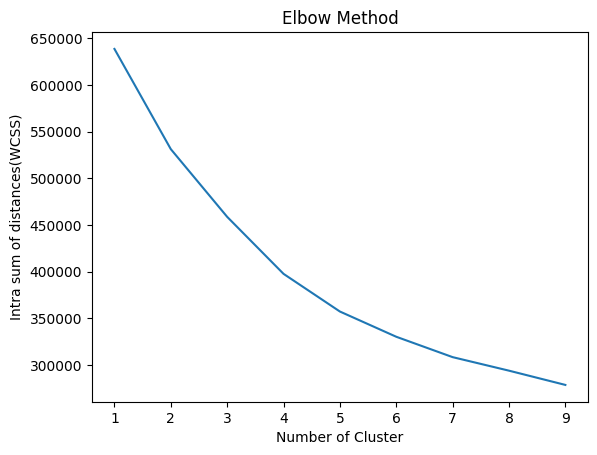

In [38]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','review_score','time_delivery','payment_installments','product_qty'])

Silhouette score for k(clusters) = 3 is 0.2768104898908131
Silhouette score for k(clusters) = 4 is 0.2424111600161093
Silhouette score for k(clusters) = 5 is 0.24017171662851122
Silhouette score for k(clusters) = 6 is 0.2937564128148448
Silhouette score for k(clusters) = 7 is 0.30240624516996667


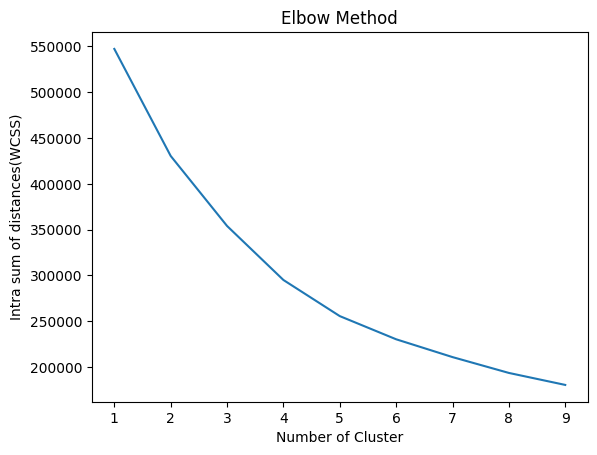

In [46]:
Find_k_with_elbow_and_silhouette(df_final, ['R','F','M','review_score','time_delivery','Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.3552379998932032
Silhouette score for k(clusters) = 4 is 0.4078939775652969
Silhouette score for k(clusters) = 5 is 0.40771054764977577
Silhouette score for k(clusters) = 6 is 0.4729377126444269
Silhouette score for k(clusters) = 7 is 0.4140446973663873


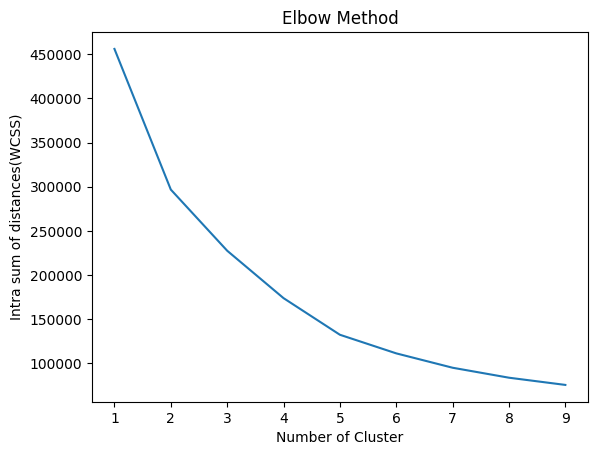

In [48]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','R','F','M','order_item_id'])

Silhouette score for k(clusters) = 3 is 0.2875201516969035
Silhouette score for k(clusters) = 4 is 0.33161673791095764
Silhouette score for k(clusters) = 5 is 0.4058417819308296
Silhouette score for k(clusters) = 6 is 0.5214844206699961
Silhouette score for k(clusters) = 7 is 0.513808988219915


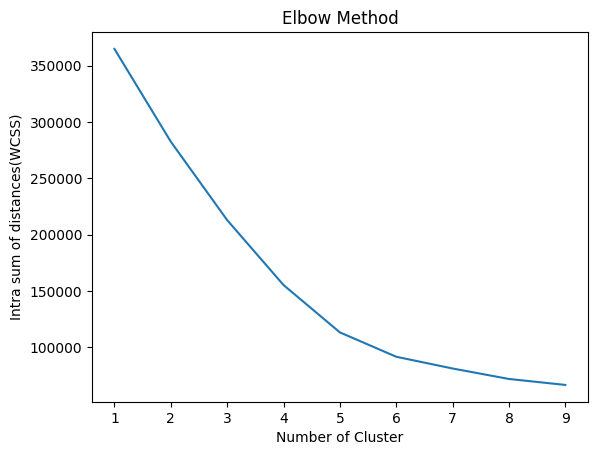

In [49]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','R','M','order_item_id'])

Silhouette score for k(clusters) = 3 is 0.5453153517004995
Silhouette score for k(clusters) = 4 is 0.5483744112181281
Silhouette score for k(clusters) = 5 is 0.6460365341753733
Silhouette score for k(clusters) = 6 is 0.652672293375146
Silhouette score for k(clusters) = 7 is 0.6703268226481399


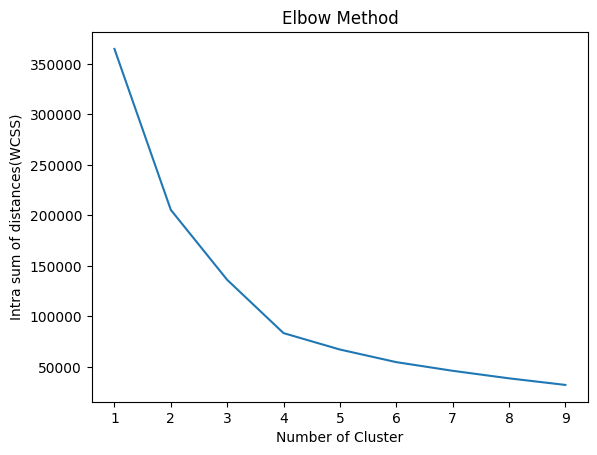

In [50]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','F','M','order_item_id'])


Silhouette score for k(clusters) = 3 is 0.8318907655928764
calinski harabasz score for k(clusters) = 3 is 729169.0312219094
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.8791001478774959
calinski harabasz score for k(clusters) = 4 is 1329776.162752251
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.9140695937836234
calinski harabasz score for k(clusters) = 5 is 2558806.303819907
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.8554453139301916
calinski harabasz score for k(clusters) = 6 is 2376063.769582618
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.8197381464557932
calinski harabasz score for k(clusters) =

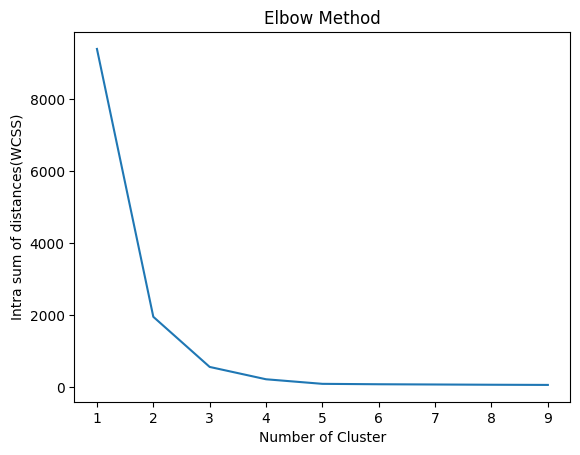

In [25]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id'])


Silhouette score for k(clusters) = 3 is 0.4759781794994324
Calinski-Harabasz score for k(clusters) = 3 is 115669.54628748044
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.4683738182600612
Calinski-Harabasz score for k(clusters) = 4 is 111791.87596322253
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.47370057789063064
Calinski-Harabasz score for k(clusters) = 5 is 107083.75043701344
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.45631525545244056
Calinski-Harabasz score for k(clusters) = 6 is 115937.26222332171
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.47986253209799673
Calinski-Harabasz score for k(clus

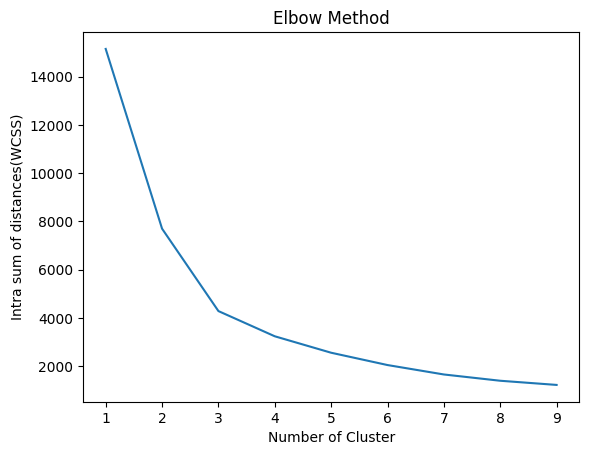

In [108]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','Recency','order_item_id'])

Silhouette score for k(clusters) = 3 is 0.5236380035921303
Calinski-Harabasz score for k(clusters) = 3 is 104902.74063103358
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.629262017393219
Calinski-Harabasz score for k(clusters) = 4 is 178565.81355052238
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.6377440461853311
Calinski-Harabasz score for k(clusters) = 5 is 182671.7889619776
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.6277078510466158
Calinski-Harabasz score for k(clusters) = 6 is 190383.75706833694
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.6333115228424689
Calinski-Harabasz score for k(clusters)

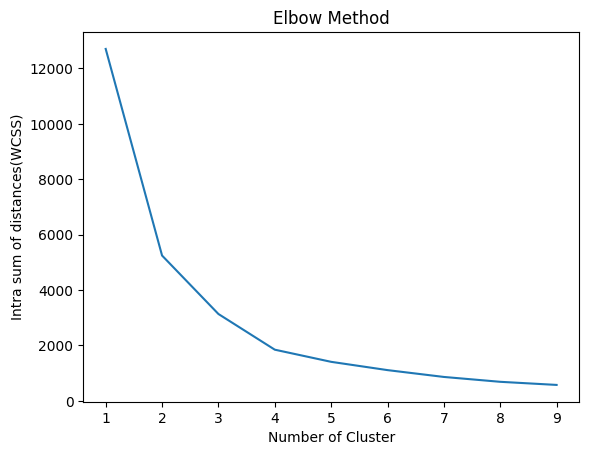

In [109]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id','haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.813866595156841
Calinski-Harabasz score for k(clusters) = 3 is 704427.3895360209
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.8535672510361552
Calinski-Harabasz score for k(clusters) = 4 is 1217093.9793996627
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.8858339710805052
Calinski-Harabasz score for k(clusters) = 5 is 2074433.1531770723
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.810818515965765
Calinski-Harabasz score for k(clusters) = 6 is 1870060.1088542747
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.7419801214283543
Calinski-Harabasz score for k(clusters) 

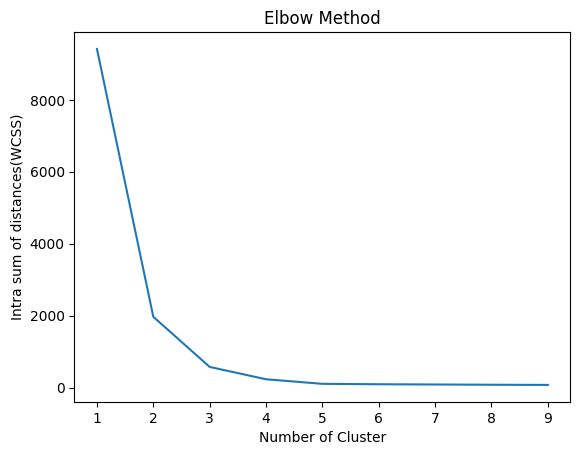

In [110]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id','Freight_ratio'])

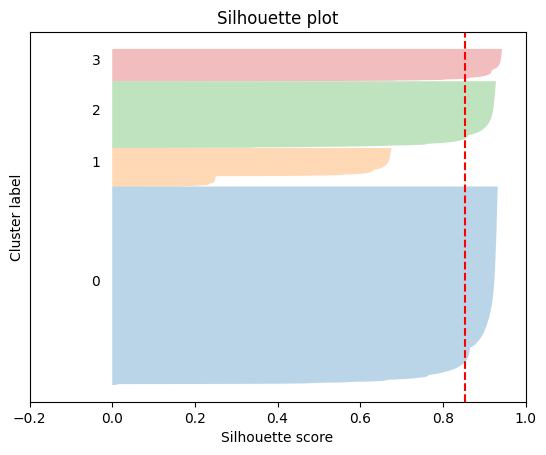

In [144]:
Silhouette_plot(df_final, 4, ['review_score','Frequency','Monetary','order_item_id','Freight_ratio'])

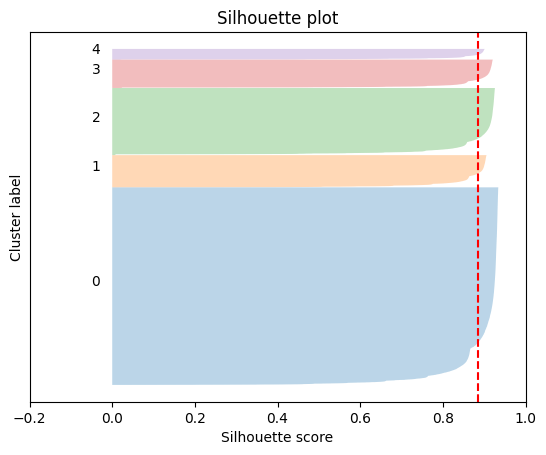

In [145]:
Silhouette_plot(df_final, 5, ['review_score','Frequency','Monetary','order_item_id','Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.5191439792435435
Calinski-Harabasz score for k(clusters) = 3 is 104376.1829484997
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.6233743377182333
Calinski-Harabasz score for k(clusters) = 4 is 176753.90892038835
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.5802885633845668
Calinski-Harabasz score for k(clusters) = 5 is 156582.52730325641
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.599007921303477
Calinski-Harabasz score for k(clusters) = 6 is 161396.3714821852
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.6083582012640786
Calinski-Harabasz score for k(clusters) 

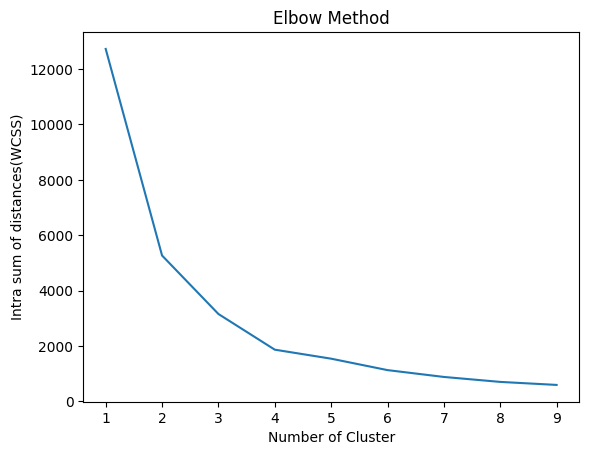

In [111]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id','haversine_distance','Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.7527069268987405
Calinski-Harabasz score for k(clusters) = 3 is 546069.0695255157
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.7663326036242104
Calinski-Harabasz score for k(clusters) = 4 is 707240.7355387756
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.7848608602520638
Calinski-Harabasz score for k(clusters) = 5 is 792788.7208399005
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.7721839498222436
Calinski-Harabasz score for k(clusters) = 6 is 727949.9235966679
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.5533542715297778
Calinski-Harabasz score for k(clusters) =

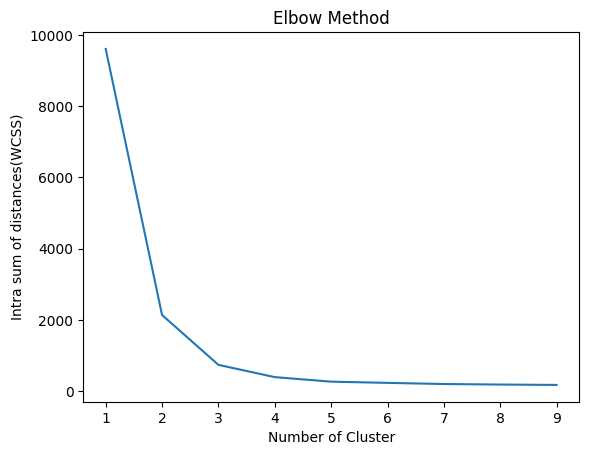

In [112]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id','Freight_ratio','time_delivery'])

Silhouette score for k(clusters) = 3 is 0.4660109802387803
Calinski-Harabasz score for k(clusters) = 3 is 142653.87085469297
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.5921742577857128
Calinski-Harabasz score for k(clusters) = 4 is 215970.25543155076
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.5739158404752401
Calinski-Harabasz score for k(clusters) = 5 is 193641.1412121805
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.5978737274388426
Calinski-Harabasz score for k(clusters) = 6 is 215020.4259120334
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.5347865069756113
Calinski-Harabasz score for k(clusters)

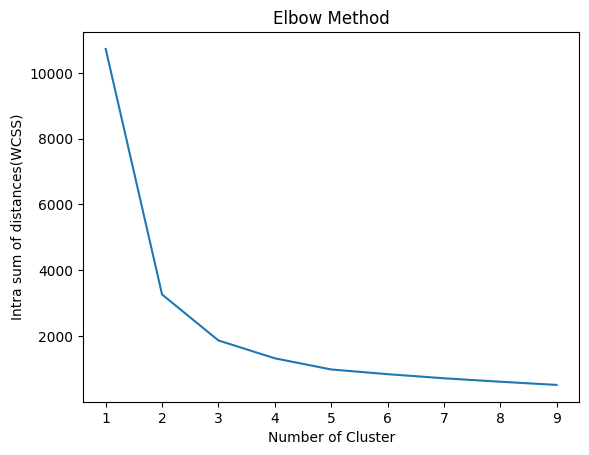

In [242]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments'])

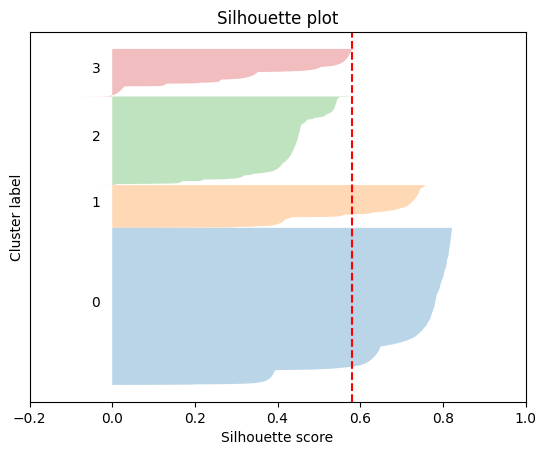

In [252]:
Silhouette_plot(df_final, 4, ['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments'])

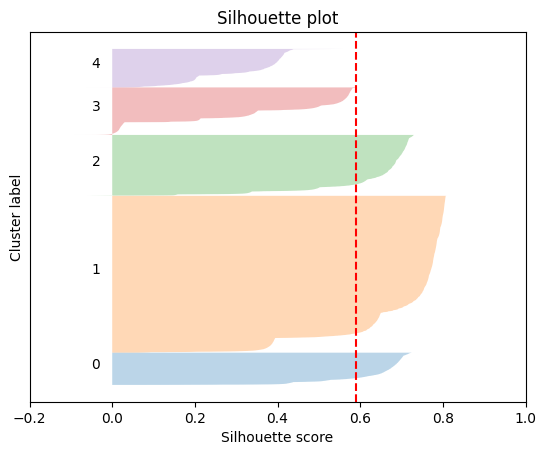

In [255]:
Silhouette_plot(df_final, 5, ['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments'])

Silhouette score for k(clusters) = 3 is 0.47097048326769997
Calinski-Harabasz score for k(clusters) = 3 is 143698.4502172654
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.47564904489232007
Calinski-Harabasz score for k(clusters) = 4 is 163212.4304177602
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.6065530434314431
Calinski-Harabasz score for k(clusters) = 5 is 229474.5335934379
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.6149966437979478
Calinski-Harabasz score for k(clusters) = 6 is 217752.44170426062
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.6108058640500551
Calinski-Harabasz score for k(clusters

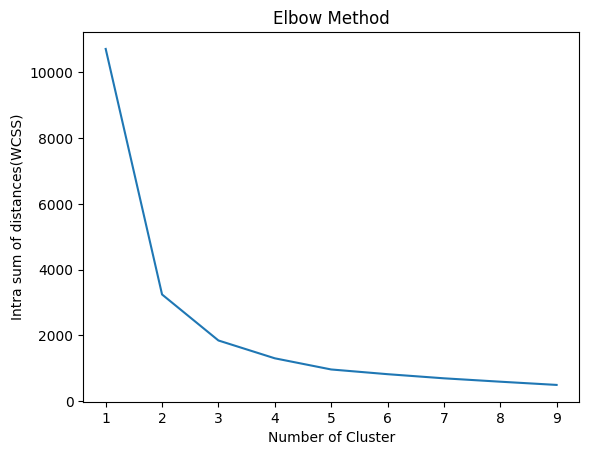

In [244]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','order_item_id','time_delivery','payment_installments' ])

Silhouette score for k(clusters) = 3 is 0.46276289551072364
Calinski-Harabasz score for k(clusters) = 3 is 110930.12626204781
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.39406754983974607
Calinski-Harabasz score for k(clusters) = 4 is 96139.7449463671
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4273099455408235
Calinski-Harabasz score for k(clusters) = 5 is 103985.62646313633
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.43152261997617075
Calinski-Harabasz score for k(clusters) = 6 is 107237.66994375159
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.4322741068160955
Calinski-Harabasz score for k(cluste

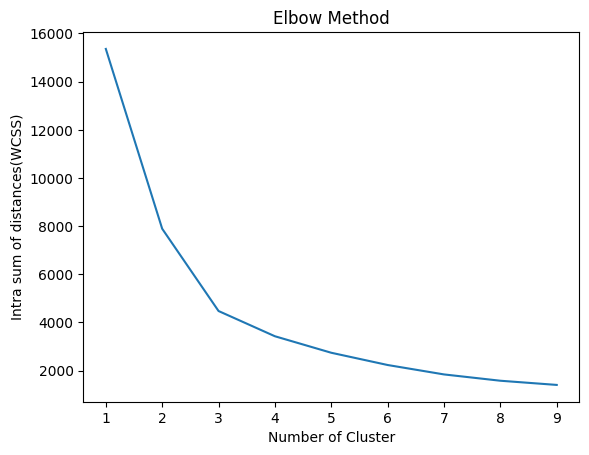

In [113]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Recency','Frequency','Monetary','order_item_id','Freight_ratio','time_delivery'])

Silhouette score for k(clusters) = 3 is 0.2695114567857491
Silhouette score for k(clusters) = 4 is 0.2954866353398997
Silhouette score for k(clusters) = 5 is 0.28918012550701533
Silhouette score for k(clusters) = 6 is 0.3062024560358138
Silhouette score for k(clusters) = 7 is 0.33432038615527004


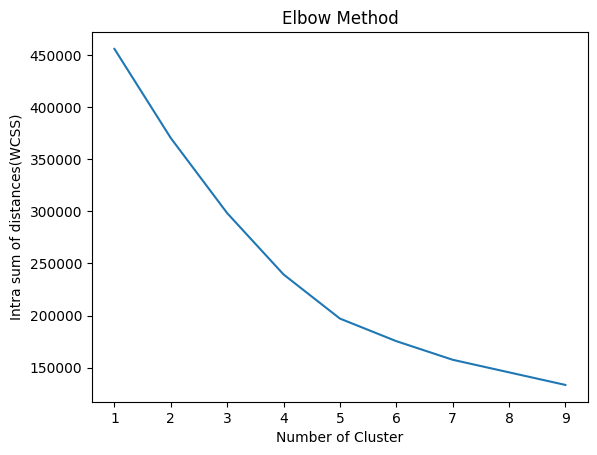

In [52]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','R','M','order_item_id','time_delivery'])


Silhouette score for k(clusters) = 3 is 0.22595725788688442
Silhouette score for k(clusters) = 4 is 0.25817219211768017
Silhouette score for k(clusters) = 5 is 0.2708872015215846
Silhouette score for k(clusters) = 6 is 0.27141031306523333
Silhouette score for k(clusters) = 7 is 0.24842999459889775


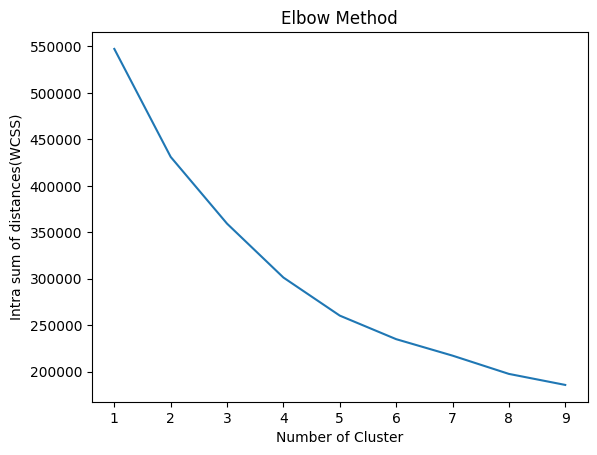

In [53]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','R','M','order_item_id','time_delivery','Freight_ratio'])


Silhouette score for k(clusters) = 3 is 0.3925981362988481
Silhouette score for k(clusters) = 4 is 0.3886258018237765
Silhouette score for k(clusters) = 5 is 0.38530508489177234
Silhouette score for k(clusters) = 6 is 0.356847055521321
Silhouette score for k(clusters) = 7 is 0.3376340945437276


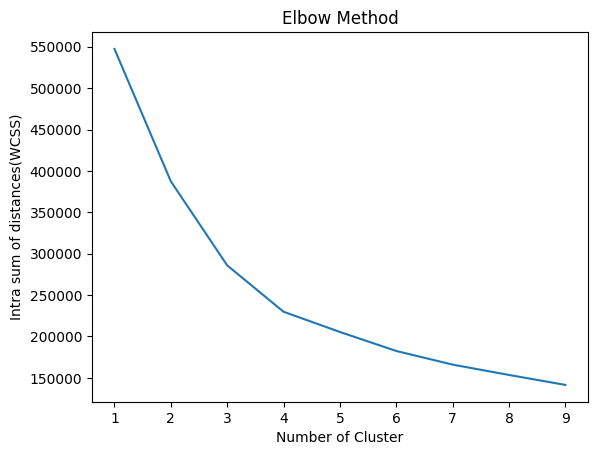

In [54]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','F','M','order_item_id','time_delivery','Freight_ratio'])


Silhouette score for k(clusters) = 3 is 0.36253844832002113
Silhouette score for k(clusters) = 4 is 0.41427736947880206
Silhouette score for k(clusters) = 5 is 0.368418902982144
Silhouette score for k(clusters) = 6 is 0.36136374473383864
Silhouette score for k(clusters) = 7 is 0.36469442251654105


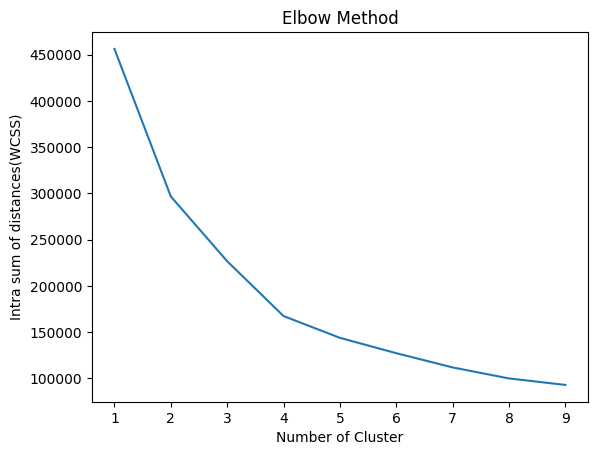

In [55]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','F','M','order_item_id','time_delivery'])


Silhouette score for k(clusters) = 3 is 0.5080033018074036
Calinski-Harabasz score for k(clusters) = 3 is 101884.9289482434
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.609663470529976
Calinski-Harabasz score for k(clusters) = 4 is 168795.94781026465
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.6170781071769379
Calinski-Harabasz score for k(clusters) = 5 is 170203.14541077346
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.5645954734505352
Calinski-Harabasz score for k(clusters) = 6 is 166337.82546286346
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.5866285719788127
Calinski-Harabasz score for k(clusters)

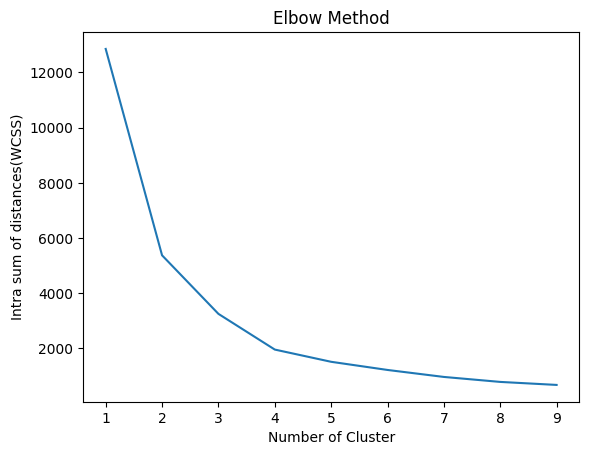

In [224]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','time_delivery','haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.7753524751150119
Calinski-Harabasz score for k(clusters) = 3 is 597861.4346843902
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.7976418207462066
Calinski-Harabasz score for k(clusters) = 4 is 843989.9446132143
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.8191533610634077
Calinski-Harabasz score for k(clusters) = 5 is 1041486.3247917857
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.7593088350644347
Calinski-Harabasz score for k(clusters) = 6 is 898910.4818568558
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.7504042643523966
Calinski-Harabasz score for k(clusters) 

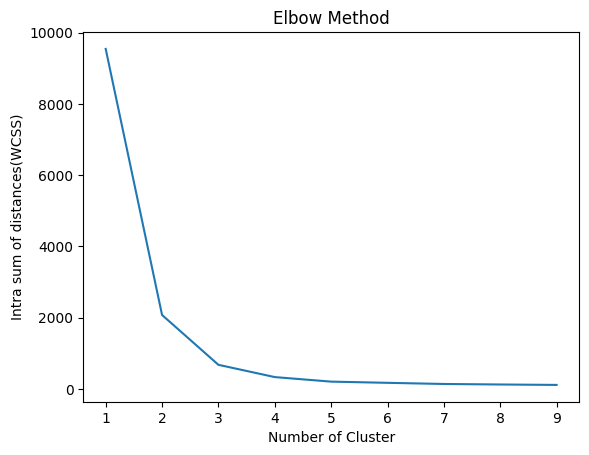

In [225]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','time_delivery'])

Silhouette score for k(clusters) = 3 is 0.7645800105459357
Calinski-Harabasz score for k(clusters) = 3 is 581162.9519729656
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.7827616246064183
Calinski-Harabasz score for k(clusters) = 4 is 797300.6078404284
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.7595119706535458
Calinski-Harabasz score for k(clusters) = 5 is 664357.8304581034
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.7927759080653736
Calinski-Harabasz score for k(clusters) = 6 is 898105.8450169996
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.5883015837856088
Calinski-Harabasz score for k(clusters) =

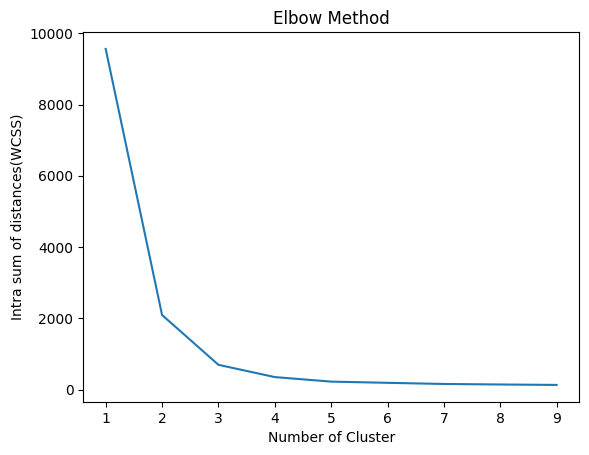

In [226]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','time_delivery', 'Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.4760454749619476
Calinski-Harabasz score for k(clusters) = 3 is 145556.76743877993
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.5940454220568966
Calinski-Harabasz score for k(clusters) = 4 is 225446.1468535811
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.6153073373055119
Calinski-Harabasz score for k(clusters) = 5 is 237550.00765138728
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.6128670799665
Calinski-Harabasz score for k(clusters) = 6 is 224720.28064207398
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.6179863168045738
Calinski-Harabasz score for k(clusters) =

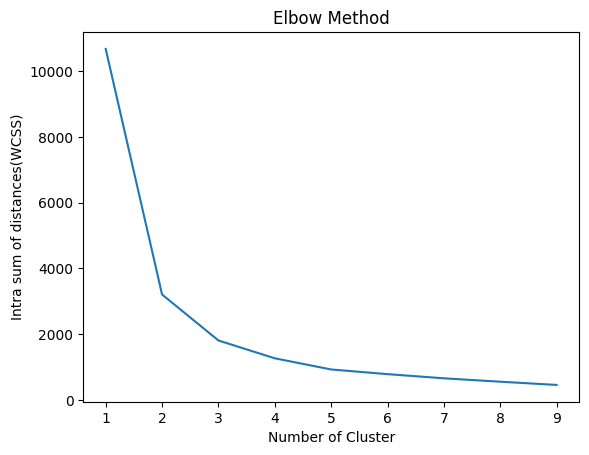

In [228]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','time_delivery', 'payment_installments'])

Silhouette score for k(clusters) = 3 is 0.4653327920288879
Calinski-Harabasz score for k(clusters) = 3 is 112048.72868077373
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.45370426442788875
Calinski-Harabasz score for k(clusters) = 4 is 107263.58585592413
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4529526566656862
Calinski-Harabasz score for k(clusters) = 5 is 103717.40297472628
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.4363832985401157
Calinski-Harabasz score for k(clusters) = 6 is 109428.35389871962
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.455304509235472
Calinski-Harabasz score for k(cluster

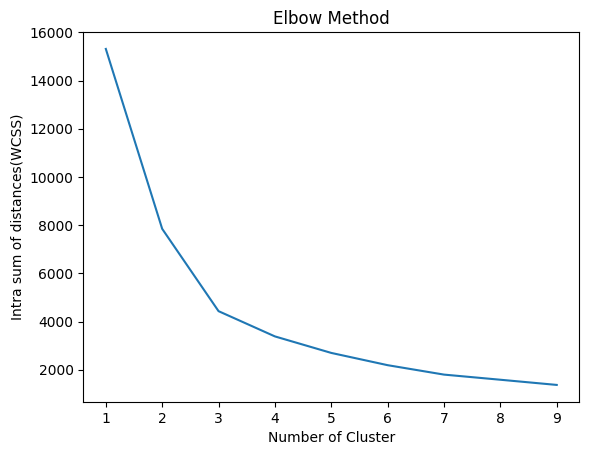

In [229]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Recency','Monetary','time_delivery', 'Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.4670888644646023
Calinski-Harabasz score for k(clusters) = 3 is 112542.25661348115
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.4562149047917058
Calinski-Harabasz score for k(clusters) = 4 is 107882.11688687718
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4050414782168503
Calinski-Harabasz score for k(clusters) = 5 is 100928.95246844577
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.43996459117723524
Calinski-Harabasz score for k(clusters) = 6 is 110408.45538863305
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.45944266383294047
Calinski-Harabasz score for k(clust

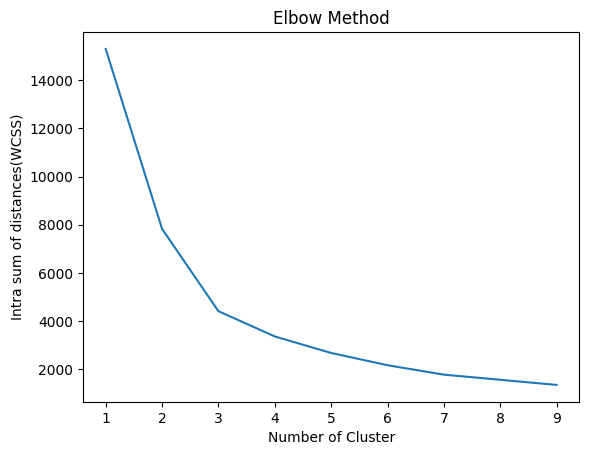

In [230]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Recency','Monetary','time_delivery'])

Silhouette score for k(clusters) = 3 is 0.4769027954581491
Calinski-Harabasz score for k(clusters) = 3 is 116354.83399590771
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.41376689089292595
Calinski-Harabasz score for k(clusters) = 4 is 101845.56716226458
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.44878603635232134
Calinski-Harabasz score for k(clusters) = 5 is 113384.64606736226
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.48292759573372235
Calinski-Harabasz score for k(clusters) = 6 is 117082.69969182751
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.4816044616837644
Calinski-Harabasz score for k(clus

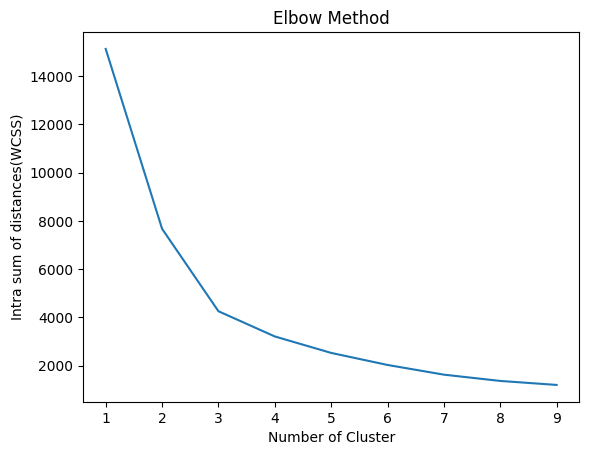

In [231]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Recency','Monetary', 'Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.8305042173281525
Calinski-Harabasz score for k(clusters) = 3 is 764096.2754728616
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.8774355451134349
Calinski-Harabasz score for k(clusters) = 4 is 1511859.913277473
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.9134523219964054
Calinski-Harabasz score for k(clusters) = 5 is 3680442.7339510135
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.8312681442634587
Calinski-Harabasz score for k(clusters) = 6 is 3064944.466150875
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.7495621481051269
Calinski-Harabasz score for k(clusters) 

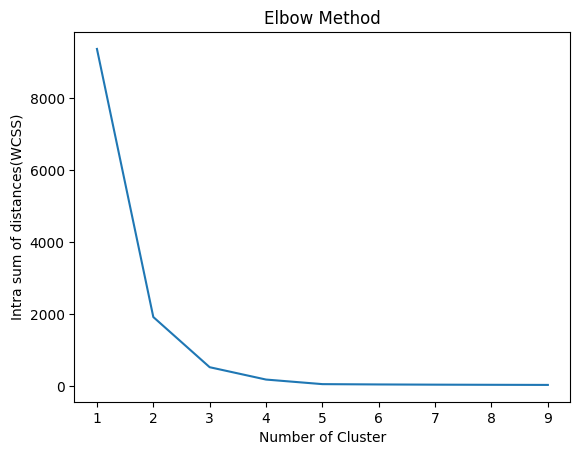

In [232]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.41870684477625764
Calinski-Harabasz score for k(clusters) = 3 is 79430.6197651493
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.4953787112361005
Calinski-Harabasz score for k(clusters) = 4 is 107537.47533792943
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4433169015397624
Calinski-Harabasz score for k(clusters) = 5 is 92966.75189955972
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.4570804135123639
Calinski-Harabasz score for k(clusters) = 6 is 90880.30200418555
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.4797740948661626
Calinski-Harabasz score for k(clusters) 

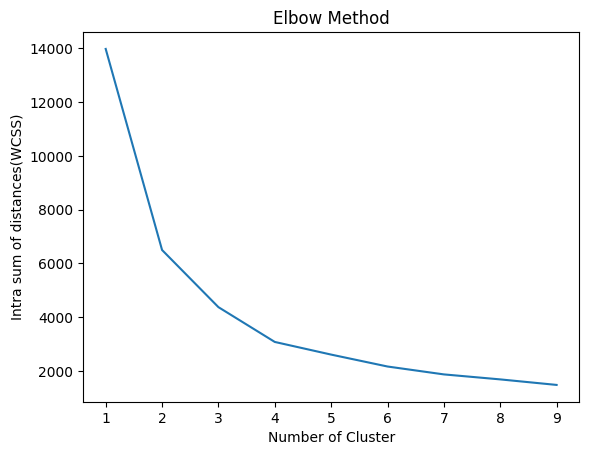

In [239]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Freight_ratio','time_delivery','haversine_distance', 'payment_installments'])

Silhouette score for k(clusters) = 3 is 0.5530365721873998
Calinski-Harabasz score for k(clusters) = 3 is 99429.33330142112
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.4928377051344113
Calinski-Harabasz score for k(clusters) = 4 is 106503.31419177877
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.47501027555045305
Calinski-Harabasz score for k(clusters) = 5 is 98104.8594829994
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.47437093823427
Calinski-Harabasz score for k(clusters) = 6 is 98105.58582947933
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.45818190597476016
Calinski-Harabasz score for k(clusters) =

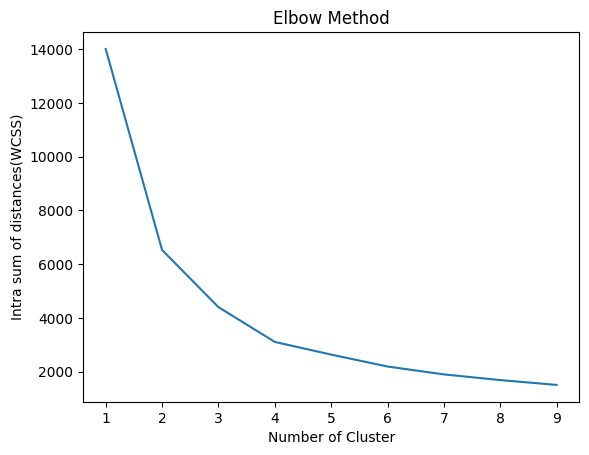

In [233]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','Freight_ratio','time_delivery','haversine_distance', 'payment_installments'])

Silhouette score for k(clusters) = 3 is 0.5544735488010404
Calinski-Harabasz score for k(clusters) = 3 is 99856.01654767347
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.49543167940012534
Calinski-Harabasz score for k(clusters) = 4 is 107154.76554642318
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.47048482509479794
Calinski-Harabasz score for k(clusters) = 5 is 98909.92690117161
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.47780614915613107
Calinski-Harabasz score for k(clusters) = 6 is 98937.57312144921
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.43895718700256453
Calinski-Harabasz score for k(cluste

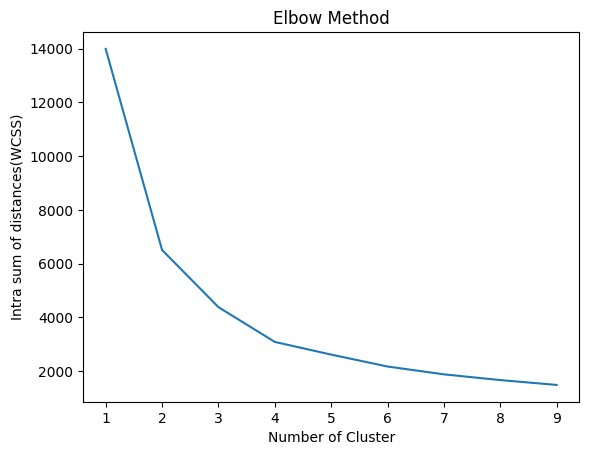

In [227]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','time_delivery','haversine_distance', 'payment_installments'])

Silhouette score for k(clusters) = 3 is 0.2573743212741148
Silhouette score for k(clusters) = 4 is 0.2908933852085024
Silhouette score for k(clusters) = 5 is 0.28526477436650716
Silhouette score for k(clusters) = 6 is 0.29505389758325845
Silhouette score for k(clusters) = 7 is 0.2723151581970613


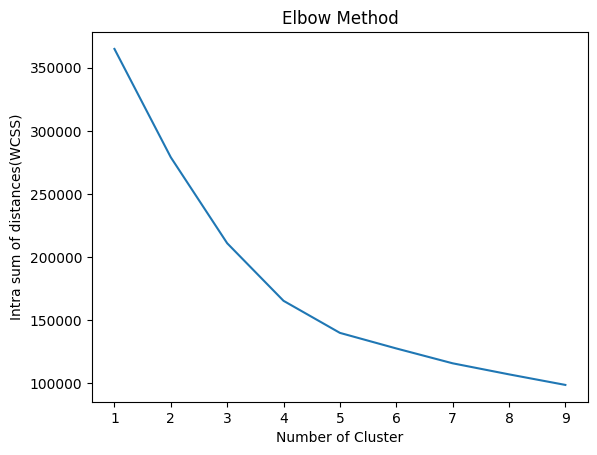

In [57]:
Find_k_with_elbow_and_silhouette(df_final, ['review_score','Monetary','order_item_id','time_delivery'])


In [ ]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','F','M','order_item_id'])


Silhouette score for k(clusters) = 3 is 0.4160992858533794
calinski harabasz score for k(clusters) = 3 is 78761.55921633213
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.49220257043666743
calinski harabasz score for k(clusters) = 4 is 106028.19733824962
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.43953467709828603
calinski harabasz score for k(clusters) = 5 is 91509.5791739955
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.46173012023026483
calinski harabasz score for k(clusters) = 6 is 91395.23616371874
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.47516697248110784
calinski harabasz score for k(cluster

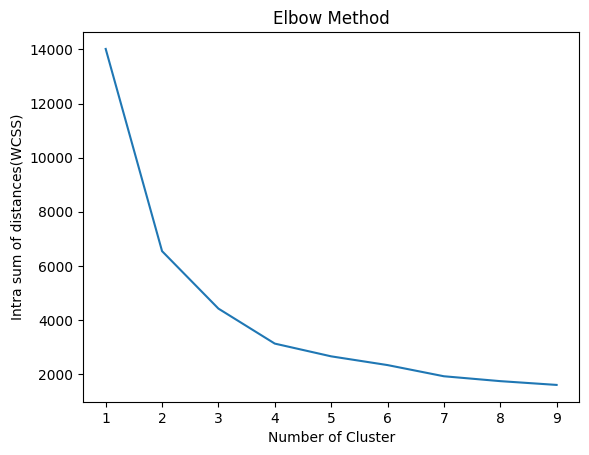

In [20]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','order_item_id','time_delivery','payment_installments', 'haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.41705361066393176
Calinski-Harabasz score for k(clusters) = 3 is 77555.28733853553
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.48970481829613094
Calinski-Harabasz score for k(clusters) = 4 is 105390.45178083245
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4711328382698606
Calinski-Harabasz score for k(clusters) = 5 is 96899.4501563178
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.4503115080814379
Calinski-Harabasz score for k(clusters) = 6 is 83444.13986461931
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.44808214428782783
Calinski-Harabasz score for k(clusters

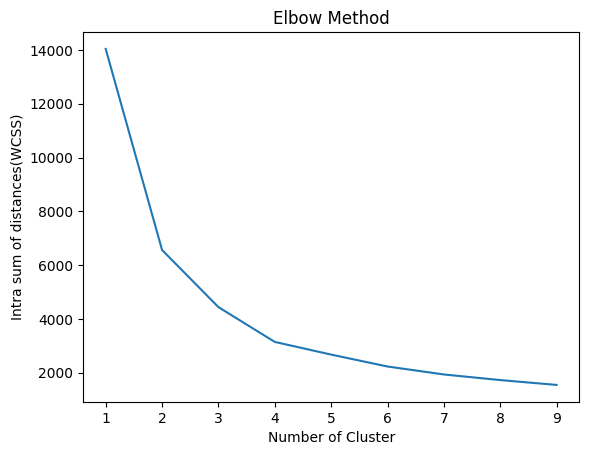

In [241]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','order_item_id','time_delivery','payment_installments', 'haversine_distance','Freight_ratio'])

Silhouette score for k(clusters) = 3 is 0.44062310866587695
calinski harabasz score for k(clusters) = 3 is 65980.11779242435
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.4494360705825128
calinski harabasz score for k(clusters) = 4 is 71186.35524060797
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.4674266013537329
calinski harabasz score for k(clusters) = 5 is 70480.73807842232
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.4874305282083551
calinski harabasz score for k(clusters) = 6 is 70217.91383929744
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.4592415939426162
calinski harabasz score for k(clusters) 

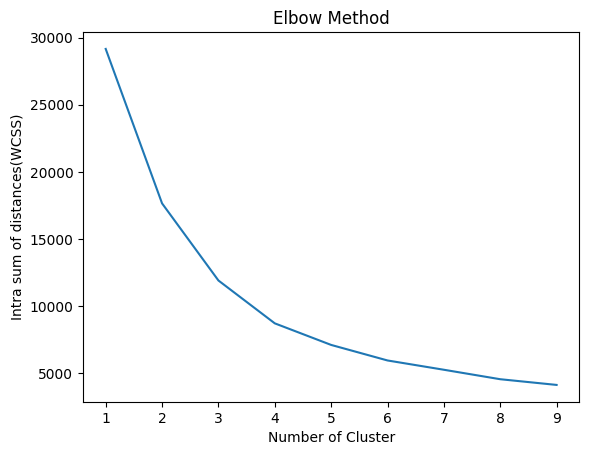

In [21]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','M','order_item_id','time_delivery','payment_installments', 'haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.33826867880767286
calinski harabasz score for k(clusters) = 3 is 56073.06975525332
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.364713431298375
calinski harabasz score for k(clusters) = 4 is 54129.13079127932
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.33578213802079426
calinski harabasz score for k(clusters) = 5 is 50809.753490601426
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.2904389294012805
calinski harabasz score for k(clusters) = 6 is 47227.69754194592
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.29013244165833374
calinski harabasz score for k(clusters

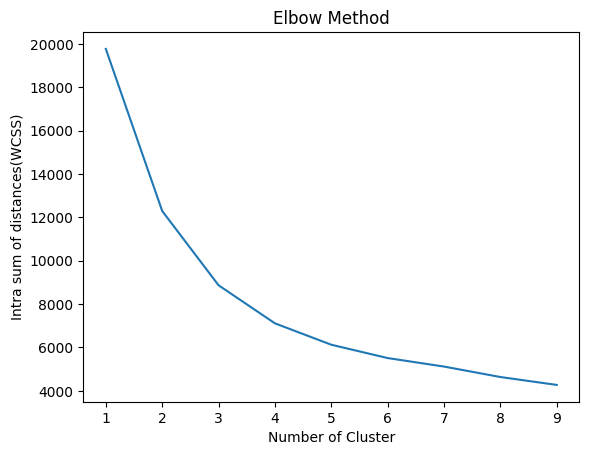

In [22]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','Recency','order_item_id','time_delivery','payment_installments', 'haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.3377328735864087
calinski harabasz score for k(clusters) = 3 is 55999.08461326183
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.3012748461520751
calinski harabasz score for k(clusters) = 4 is 46444.32644195852
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.3353817633381399
calinski harabasz score for k(clusters) = 5 is 50712.443335301425
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.33331557247704674
calinski harabasz score for k(clusters) = 6 is 46335.937767994605
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.29531683560695465
calinski harabasz score for k(cluster

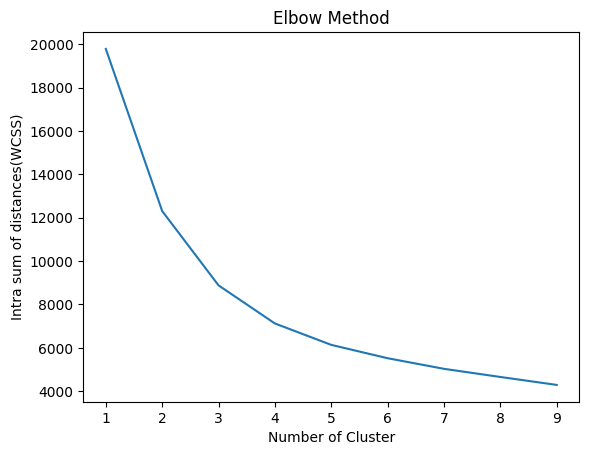

In [23]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Monetary','Recency','Frequency','order_item_id','time_delivery','payment_installments', 'haversine_distance'])

Silhouette score for k(clusters) = 3 is 0.7624974759165379
Calinski-Harabasz score for k(clusters) = 3 is 560785.449583875
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 4 is 0.7797905380133198
Calinski-Harabasz score for k(clusters) = 4 is 743734.7754990129
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 5 is 0.7993115798273048
Calinski-Harabasz score for k(clusters) = 5 is 854608.6415194196
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 6 is 0.7876660726202039
Calinski-Harabasz score for k(clusters) = 6 is 793602.4046902242
----------------------------------------------------------------------------------------------------
Silhouette score for k(clusters) = 7 is 0.7661395353101902
Calinski-Harabasz score for k(clusters) = 

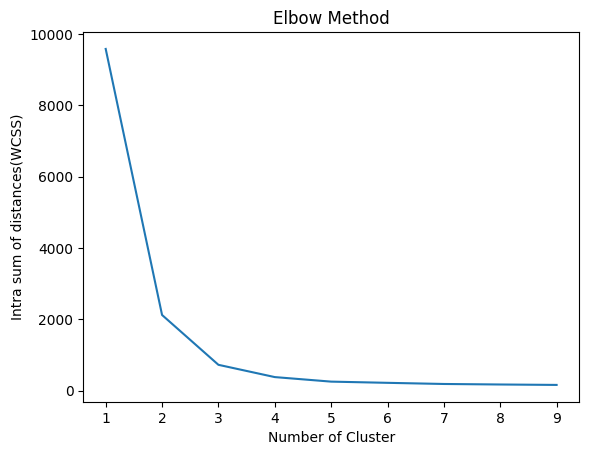

In [166]:
Find_k_with_elbow_and_silhouette_minmaxScaled(df_final, ['review_score','Frequency','Monetary','order_item_id','time_delivery'])

In [5]:
#Try with categorical attributes

numerical_features = ['review_score','Recency','Frequency','Monetary','time_delivery','construction','electronics','fashion', 'food_drink','furniture','gifts','health_beauty','home','misc','sports_leisure','supplies']

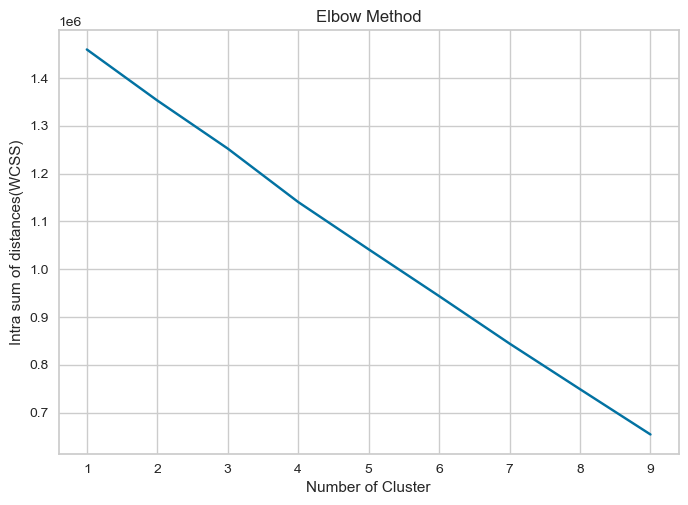

In [66]:
df_cat = df_final.loc[:, numerical_features]

scaler = StandardScaler()
scaler.fit(df_cat)
df_ssed = scaler.transform(df_cat)

max_cluster = 10
clusters = range(1,max_cluster)
intra_sum_of_square_list = []
for i in clusters:
    km = KMeans(n_clusters=i,init="k-means++",n_init=10,max_iter=300)
    km.fit(df_ssed)
    intra_sum_of_square_list.append(km.inertia_)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Elbow Method")
ax.set_xlabel("Number of Cluster")
ax.set_ylabel("Intra sum of distances(WCSS)")
plt.plot(clusters,intra_sum_of_square_list)

In [ ]:
# We can't choose k with the Elbow method, thus we will try to find out with silhouette score

In [ ]:
# It seems that the optimize number of cluster is 12

In [69]:
for i in range(3,8):
    labels=KMeans(n_clusters=i, random_state=1, n_init = "auto").fit(df_ssed).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(df_ssed,labels,metric="euclidean",random_state=1)))

Silhouette score for k(clusters) = 10 is 0.4631563946824416
Silhouette score for k(clusters) = 11 is 0.48494343799190376
Silhouette score for k(clusters) = 12 is 0.4914835673686764
Silhouette score for k(clusters) = 13 is 0.4907608289099402


In [6]:
df_cat_data = df_final[numerical_features]

scaler = MinMaxScaler()
scaler.fit(df_cat_data)
df_mmsed = scaler.transform(df_cat_data)

kmeans = KMeans(n_clusters=12,init="k-means++",n_init=10,max_iter=300, random_state = 1)
#compute k-means clustering on preprocessed data
kmeans.fit(df_mmsed)

#Extract cluster label from labels_ attribute
cluster_labels = kmeans.labels_

df_k = df_cat_data.assign(Cluster = cluster_labels)

dic_agg = {}
for feature in numerical_features :
    dic_agg[feature] = 'mean'

df_k = df_k.groupby(['Cluster']).agg(dic_agg)


In [9]:
plot_radars(data=df_k, group='Cluster')


In [150]:
df_choice.order_item_id.value_counts()

1.000000     79211
2.000000      8606
3.000000      1377
4.000000       690
1.500000       532
6.000000       236
5.000000       219
2.500000        65
7.000000        43
1.666667        37
1.333333        37
8.000000        25
12.000000       19
3.500000        16
10.000000       14
9.000000        10
11.000000        9
4.500000         8
1.250000         7
5.500000         6
2.333333         5
14.000000        5
2.666667         4
15.000000        4
24.000000        4
3.333333         3
13.000000        3
21.000000        3
2.250000         2
1.200000         2
20.000000        2
1.800000         2
1.750000         2
1.555556         1
4.666667         1
7.500000         1
1.833333         1
1.714286         1
6.500000         1
3.666667         1
37.500000        1
19.000000        1
1.428571         1
38.000000        1
16.000000        1
22.000000        1
1.285714         1
1.400000         1
26.000000        1
17.500000        1
Name: order_item_id, dtype: int64

In [175]:
df_choice = df_final[['review_score','Frequency','Monetary','order_item_id','Freight_ratio']]
X_scaled = scaler.fit_transform(df_choice)
X_scaled = pd.DataFrame(X_scaled, index=df_choice.index, columns=df_choice.columns)
kmeans = KMeans(n_clusters=5,init="k-means++",n_init=10,max_iter=300, random_state = 1)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
X_scaled = X_scaled.assign(kmeans_label = cluster_labels)
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

review_score  Frequency  Monetary  order_item_id  Freight_ratio
kmeans_label                                                                 
0                 0.999894   0.002646  0.010750       0.004222       0.014073
1                 0.000246   0.005573  0.013088       0.010558       0.015009
2                 0.751534   0.003016  0.010692       0.004544       0.014587
3                 0.501919   0.003879  0.010381       0.005821       0.015265
4                 0.252745   0.005877  0.012011       0.009026       0.015432

In [176]:
plot_radars(data=X_scaled_clusters, group='kmeans_label')

review_score  Frequency    Monetary  order_item_id
Cluster                                                    
0            4.997548   1.200601  145.698960       1.156347
1            1.002959   1.423191  177.465916       1.393517
2            3.996709   1.219310  144.425117       1.168731
3            2.729716   1.301914  143.899274       1.244367

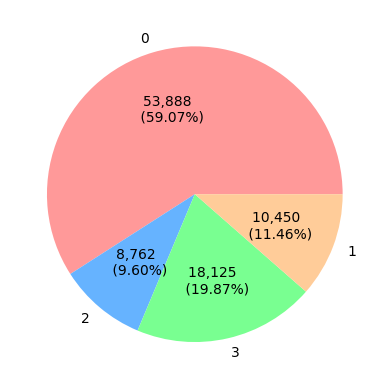

Cluster
0    53888
1     8762
2    18125
3    10450
dtype: int64


In [222]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Frequency','Monetary','order_item_id'])

review_score    Monetary  Freight_ratio  time_delivery  \
Cluster                                                           
0            4.530814  174.856005       0.442951      18.807652   
1            3.699471  139.336248       0.296664      12.363290   
2            1.247330  172.567199       0.324001      20.790939   
3            4.997402  141.477655       0.285317      10.366621   

         haversine_distance  payment_installments  
Cluster                                            
0               1342.045296              3.352558  
1                314.692289              2.775874  
2                486.244869              3.154751  
3                307.613717              2.811147

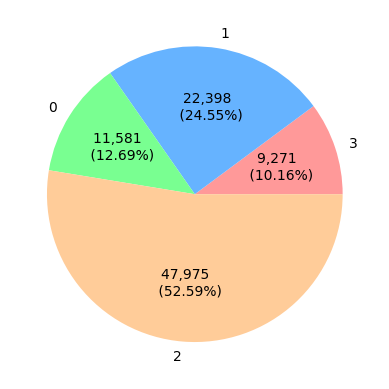

Cluster
0     9271
1    22398
2    11581
3    47975
dtype: int64


In [240]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Monetary','Freight_ratio','time_delivery','haversine_distance', 'payment_installments'])

review_score    Monetary  Item_per_order  Freight_ratio  \
Cluster                                                            
0            4.997331  116.292235        1.153958       0.328199   
1            1.247265  172.791417        1.375237       0.324013   
2            3.679000  129.449569        1.181916       0.327116   
3            4.868070  267.182916        1.169824       0.198555   

         time_delivery  payment_installments  
Cluster                                       
0            11.019814              1.685700  
1            20.788060              3.157757  
2            13.381230              2.396357  
3            12.116983              7.628732

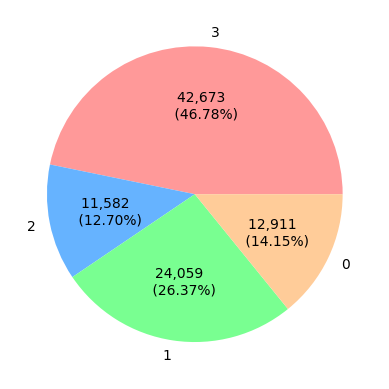

In [295]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Monetary','Item_per_order','Freight_ratio','time_delivery','payment_installments' ])

In [253]:
df_choice = df_final[['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments']]
X_scaled = scaler.fit_transform(df_choice)
X_scaled = pd.DataFrame(X_scaled, index=df_choice.index, columns=df_choice.columns)
kmeans = KMeans(n_clusters=4,init="k-means++",n_init=10,max_iter=300, random_state = 1)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
X_scaled = X_scaled.assign(kmeans_label = cluster_labels)
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

review_score  Monetary  order_item_id  Freight_ratio  \
kmeans_label                                                         
0                 0.999333  0.008590       0.004161       0.015303   
1                 0.061816  0.012794       0.010142       0.015108   
2                 0.669750  0.009569       0.004917       0.015252   
3                 0.967018  0.019818       0.004590       0.009258   

              time_delivery  payment_installments  
kmeans_label                                       
0                  0.048172              0.070237  
1                  0.095135              0.131573  
2                  0.059525              0.099848  
3                  0.053447              0.317864

In [254]:
plot_radars(data=X_scaled_clusters, group='kmeans_label')

review_score    Monetary  time_delivery  haversine_distance  \
Cluster                                                                
0            4.571021  176.621444      18.783535         1349.166244   
1            1.247252  172.537684      20.794686          486.489196   
2            4.997375  141.510919      10.366557          307.607877   
3            3.692073  138.946248      12.438511          322.450433   

         payment_installments  
Cluster                        
0                    3.391817  
1                    3.154587  
2                    2.811328  
3                    2.765911

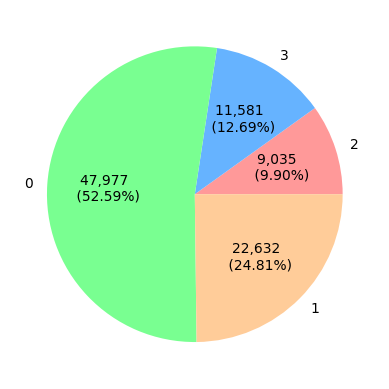

Cluster
0     9035
1    11581
2    47977
3    22632
dtype: int64


In [237]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Monetary','time_delivery','haversine_distance', 'payment_installments'])

review_score    Monetary  time_delivery  payment_installments
Cluster                                                               
0            4.868060  266.980994      12.117302              7.628974
1            1.247265  172.791417      20.788060              3.157757
2            4.997331  116.356857      11.019743              1.685766
3            3.679000  129.449569      13.381230              2.396357

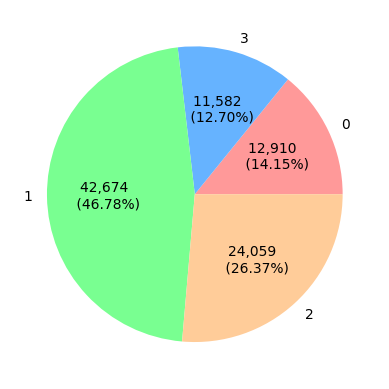

Cluster
0    12910
1    11582
2    42674
3    24059
dtype: int64


In [238]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Monetary','time_delivery', 'payment_installments'])

review_score    Monetary  time_delivery  Freight_ratio
Cluster                                                        
0            4.998019  145.600113      11.184450       0.301774
1            1.003088  177.355569      21.964056       0.322032
2            3.998121  144.721472      12.845346       0.313055
3            2.729773  143.988604      15.438026       0.328541

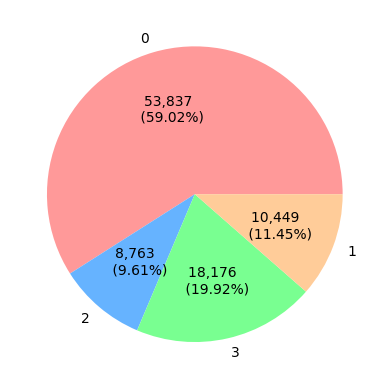

Cluster
0    53837
1     8763
2    18176
3    10449
dtype: int64


In [235]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Monetary','time_delivery', 'Freight_ratio'])

review_score    Monetary  time_delivery  Freight_ratio
Cluster                                                        
0            2.007011  161.595040      17.245848       0.330838
1            4.998315  145.531843      11.182846       0.301747
2            4.001092  144.313716      12.837372       0.313027
3            3.003672  139.636013      14.794693       0.327858
4            1.000471  176.778632      21.957177       0.321899

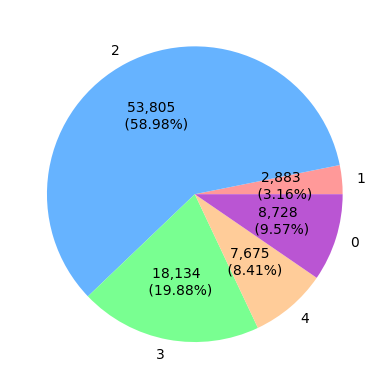

Cluster
0     2883
1    53805
2    18134
3     7675
4     8728
dtype: int64


In [234]:
compute_kmeans_df_and_plot(df_final, 5, ['review_score','Monetary','time_delivery', 'Freight_ratio'])

         review_score  Frequency    Monetary  order_item_id  Freight_ratio  \
Cluster                                                                      
0            2.009054   1.438342  162.282864       1.334542       0.330885   
1            4.998723   1.197820  145.461226       1.156202       0.301762   
2            1.000471   1.411091  176.778632       1.390582       0.321899   
3            3.006200   1.284785  139.995664       1.215753       0.327644   
4            4.003047   1.218500  144.256192       1.168085       0.313015   

         time_delivery  
Cluster                 
0            17.206833  
1            11.182575  
2            21.957177  
3            14.785936  
4            12.839563  
          Size
Cluster       
0         2895
1        53761
2         8728
3         7690
4        18151


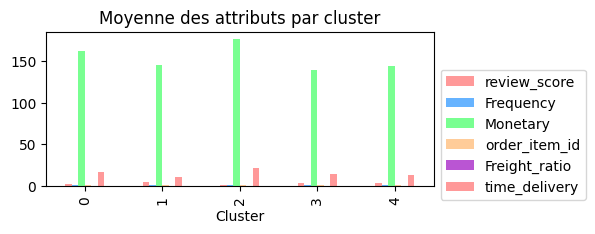

In [160]:
compute_kmeans_df_and_plot(df_final, 5, ['review_score','Frequency','Monetary','order_item_id','Freight_ratio','time_delivery'])

review_score    Monetary  order_item_id  time_delivery  \
Cluster                                                           
0            2.729670  143.912409       1.244892      15.439466   
1            4.998323  116.119224       1.153743      11.016861   
2            3.998038  125.940416       1.166338      12.716528   
3            4.868666  266.989371       1.169479      12.115517   
4            1.003088  177.355569       1.393016      21.964056   

         payment_installments  
Cluster                        
0                    2.953429  
1                    1.684217  
2                    2.161612  
3                    7.630924  
4                    3.187919

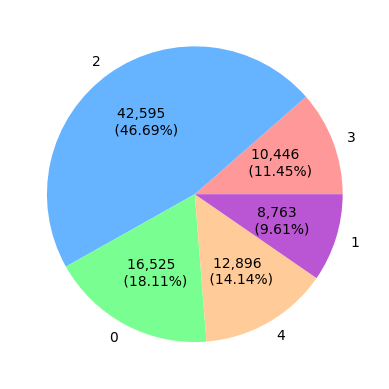

Cluster
0    10446
1    42595
2    16525
3    12896
4     8763
dtype: int64


In [248]:
compute_kmeans_df_and_plot(df_final, 5, ['review_score','Monetary','order_item_id','time_delivery','payment_installments' ])

In [190]:
df_choice = df_final[['review_score','Frequency','Monetary','order_item_id','time_delivery']]
X_scaled = scaler.fit_transform(df_choice)
X_scaled = pd.DataFrame(X_scaled, index=df_choice.index, columns=df_choice.columns)
kmeans = KMeans(n_clusters=4,init="k-means++",n_init=10,max_iter=300, random_state = 1)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
X_scaled = X_scaled.assign(kmeans_label = cluster_labels)
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
print(X_scaled_clusters)
plot_radars(data=X_scaled_clusters, group='kmeans_label')

              review_score  Frequency  Monetary  order_item_id  time_delivery
kmeans_label                                                                 
0                 0.999502   0.002692  0.010770       0.004218       0.048964
1                 0.000772   0.005697  0.013134       0.010622       0.100789
2                 0.749523   0.003018  0.010707       0.004580       0.056948
3                 0.432443   0.004098  0.010651       0.006616       0.069414


         review_score  Frequency    Monetary  order_item_id  time_delivery
Cluster                                                                   
0            1.000471   1.411091  176.778632       1.390582      21.957177
1            4.998408   1.198364  145.511590       1.156110      11.182622
2            4.001726   1.217528  144.191391       1.168252      12.839235
3            3.005036   1.283854  139.898857       1.216034      14.793665
4            2.008375   1.437565  162.005292       1.335005      17.219744
          Size
Cluster       
0         8728
1        53795
2        18131
3         7680
4         2891


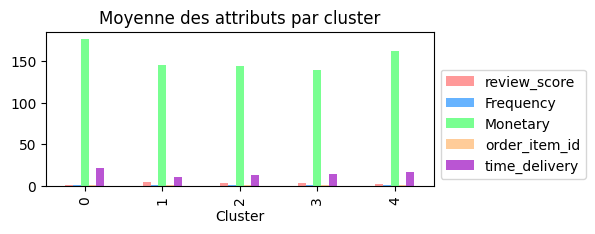

In [164]:
compute_kmeans_df_and_plot(df_final, 5, ['review_score','Frequency','Monetary','order_item_id','time_delivery'])

review_score  Frequency    Monetary  order_item_id  time_delivery
Cluster                                                                   
0            4.998010   1.199227  145.591859       1.156084      11.184521
1            1.003088   1.421545  177.355569       1.393016      21.964056
2            3.998093   1.223329  144.745876       1.169477      12.845227
3            2.729773   1.303283  143.988604       1.244774      15.438026

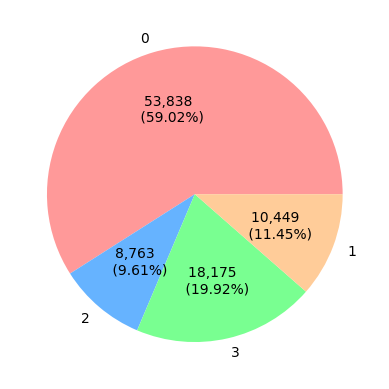

Cluster
0    53838
1     8763
2    18175
3    10449
dtype: int64


In [215]:
compute_kmeans_df_and_plot(df_final, 4, ['review_score','Frequency','Monetary','order_item_id','time_delivery'])

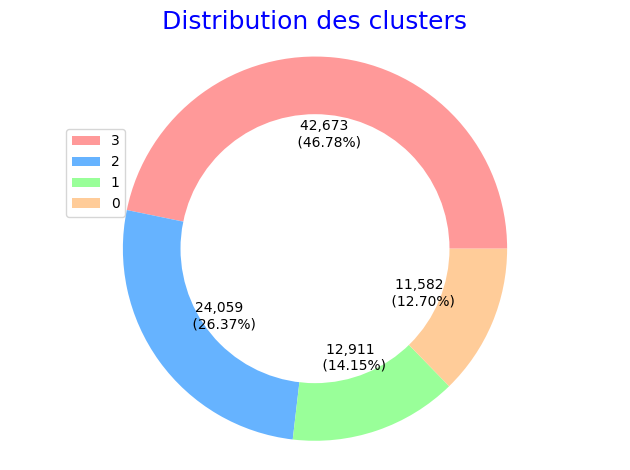

In [287]:
df_pie = df_final[['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments']]

scaler = MinMaxScaler()
scaler.fit(df_pie)
df_mmsed = scaler.transform(df_pie)

kmeans = KMeans(n_clusters=4,init="k-means++",n_init=10,max_iter=300, random_state = 1)

#compute k-means clustering on preprocessed data
kmeans.fit(df_mmsed)

    #Extract cluster label from labels_ attribute
cluster_labels = kmeans.labels_

    #create a cluster label column in the original dataframe
df_k = df_pie.assign(Cluster = cluster_labels)

# Pie chart (plots value counts in this case)
labels = df_k['Cluster'].dropna().unique()
actual_values = df_k['Cluster'].value_counts(dropna=True)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#fffd55']
fig1, ax1 = plt.subplots()
values=df_k['Cluster'].value_counts(dropna=True)
plt.pie(actual_values, colors = colors, autopct= lambda x: '{:,.0f} \n ({:.2f}%)'.format(x * sum(actual_values)/100,x, startangle=90))

#create a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 

# A separate legend with labels (drawn to the bottom left of the pie in this case) 
plt.legend(labels, bbox_to_anchor = (0.2, .8))
plt.title("Distribution des clusters", fontsize = 18, color = "blue")

plt.tight_layout()
plt.show()

In [ ]:
# Results of the tests:

# 1. There is a trade off between well segmented clustering and marketing meaningfull clustering.
# We can find Kmeans silhouette score up to 0.9 but harder to interpret when it comes to visualization and means.
# Thus, we will mitigate this choice by choosing 6 variables that allows an average clustering and meaningfull interpretation.

# 'review_score','Monetary','item_per_order','Freight_ratio','time_delivery','payment_installments'

# 2. We can see that the encoded categorical variables take over the clustering, 
# Thus it is hard to take advantage of originally numerical variables.
# As a result we won't be using these variables in our final clustering

In [257]:
#After that, we will also perform a PCA to see if we can reduce the dimensions of the clustering

customer_unique_id  review_score  Recency  Frequency  \
0      0000366f3b9a7992bf8c76cfdf3221e2           5.0      112          1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f           4.0      115          1   
2      0000f46a3911fa3c0805444483337064           3.0      537          1   
3      0000f6ccb0745a6a4b88665a16c9f078           4.0      321          1   
4      0004aac84e0df4da2b147fca70cf8255           5.0      288          1   
...                                 ...           ...      ...        ...   
91220  fffcf5a5ff07b0908bd4e2dbc735a684           5.0      447          2   
91221  fffea47cd6d3cc0a88bd621562a9d061           4.0      262          1   
91222  ffff371b4d645b6ecea244b27531430a           5.0      568          1   
91223  ffff5962728ec6157033ef9805bacc48           5.0      119          1   
91224  ffffd2657e2aad2907e67c3e9daecbeb           5.0      484          1   

       Monetary  R  F  M  RFM_Segment  RFM_Score  ... food_drink  furniture  \
0        129.90  3  1  2          312          6  ...          0          1   
1         18.90  3  1  1          311          5  ...          0          0   
2         69.00  1  1  2          112          4  ...          0          0   
3         25.99  1  1  1          111          3  ...          0          0   
4        180.00  2  1  3          213          6  ...          0          0   
...         ... .. .. ..          ...        ...  ...        ...        ...   
91220   1570.00  1  2  3          123          6  ...          0          0   
91221     64.89  2  1  2          212          5  ...          0          0   
91222     89.90  1  1  2          112          4  ...          0          0   
91223    115.00  3  1  2          312          6  ...          0          0   
91224     56.99  1  1  1          111          3  ...          0          0   

       gifts  health_beauty  home  misc  sports_leisure  supplies  \
0          0              0     0     0               0         0   
1          0              1     0     0               0         0   
2          0              0     0     0               0         1   
3          0              0     0     0               0         0   
4          0              0     0     0               0         0   
...      ...            ...   ...   ...             ...       ...   
91220      0              1     0     0               0         0   
91221      0              1     0     0               0         0   
91222      0              0     0     0               0         1   
91223      1              0     0     0               0         0   
91224      0              1     0     0               0         0   

       Freight_ratio  haversine_distance  
0           0.092379          209.713834  
1           0.438624          209.713834  
2           0.249565          125.363853  
3           0.678338         1574.231129  
4           0.093833          209.713834  
...              ...                 ...  
91220       0.320939         1486.897041  
91221       0.303437         1063.469329  
91222       0.250945          882.561907  
91223       0.162522          669.215559  
91224       0.255659          108.557249  

[91225 rows x 27 columns]

# PCA <a class="anchor" id='section_1_2' ></a>

In [261]:
df_pca = df_final.loc[:,['customer_unique_id','review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments']].set_index('customer_unique_id')

features = data_pca.columns

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.219506 -0.203556 -0.073563  0.226220 -0.008197 -0.009713 -0.004377   
1  0.024949 -0.212620 -0.109251 -0.067623 -0.032329 -0.009096 -0.004613   
2  0.294089  0.487793 -0.193258  0.208291  0.053697 -0.013782 -0.011347   
3  0.077140  0.183663  0.561807  0.002042 -0.011817 -0.010802 -0.012868   
4 -0.213559  0.086710 -0.098832  0.136947  0.021624 -0.005500  0.002083   

        PC8       PC9  
0 -0.005835 -0.000259  
1  0.003662 -0.000144  
2 -0.001878  0.000078  
3  0.003359  0.000032  
4 -0.004389 -0.000297

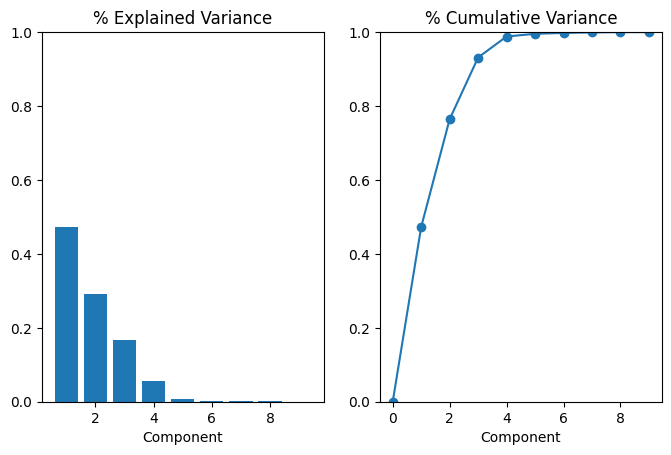

In [262]:
# Look at explained variance
plot_variance(pca);

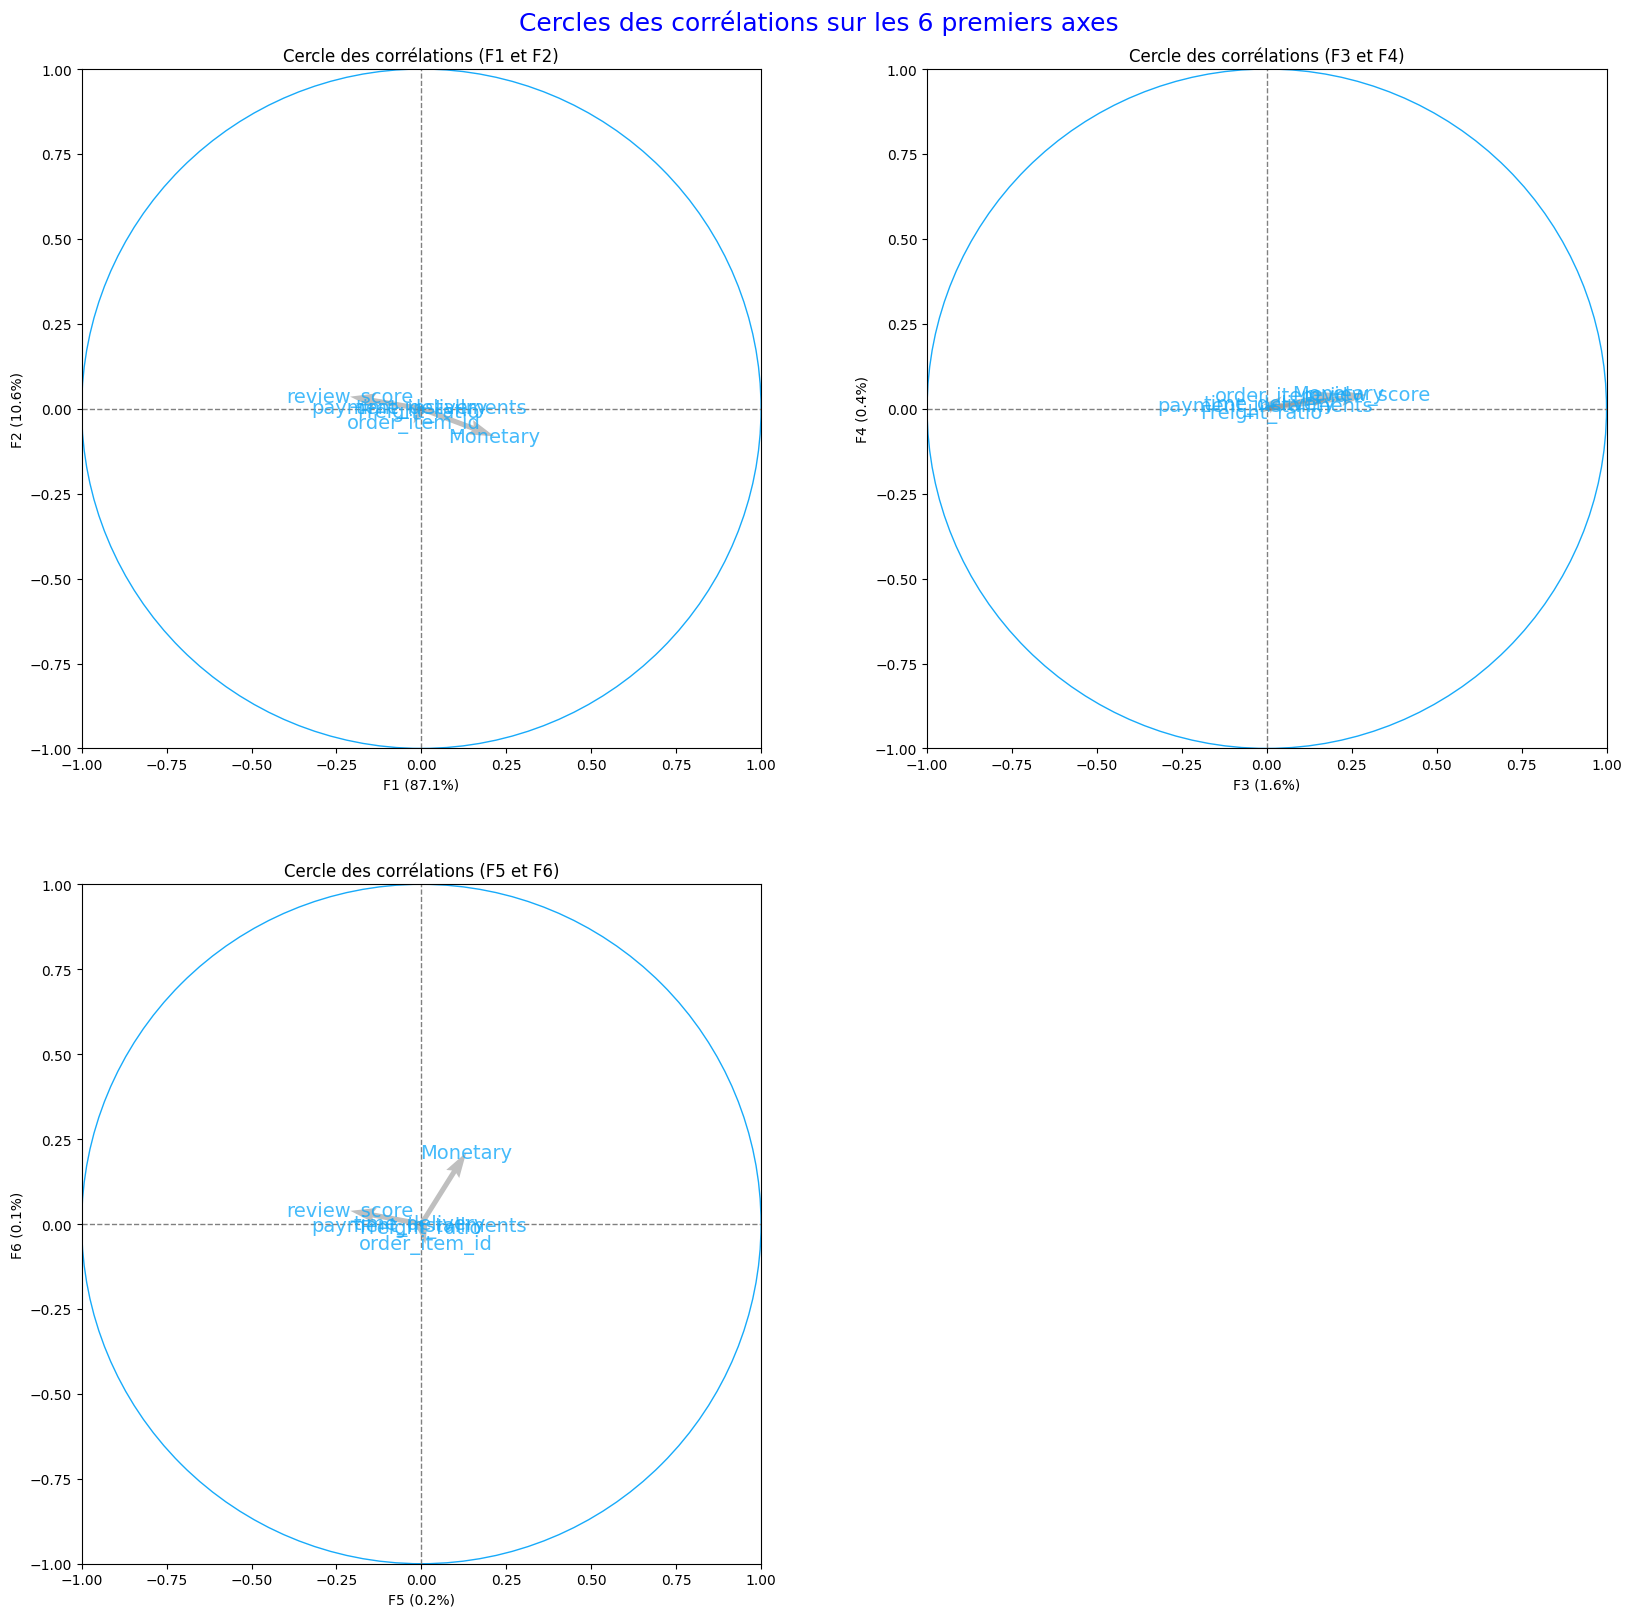

In [276]:
scaler = MinMaxScaler()
scaler.fit(df_pca[['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments']])
df_mmsed = scaler.transform(df_pca)

n_comp = 6

# perform PCA on the data
pca = PCA(n_components=n_comp)
pcs = pca.fit_transform(df_mmsed)

# specify the feature labels (optional)
labels = df_pca.columns

# call the cerle_corr function with the appropriate arguments
cerle_corr(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels=labels, label_rotation=0)

In [ ]:
# The PCA shows that it is hard to find groups of variables, 
# Correlation circles shows that variables are not well represented within components.

# DBSCAN clustering <a class="anchor" id='section_1_3' ></a>

(0.0, 0.2)

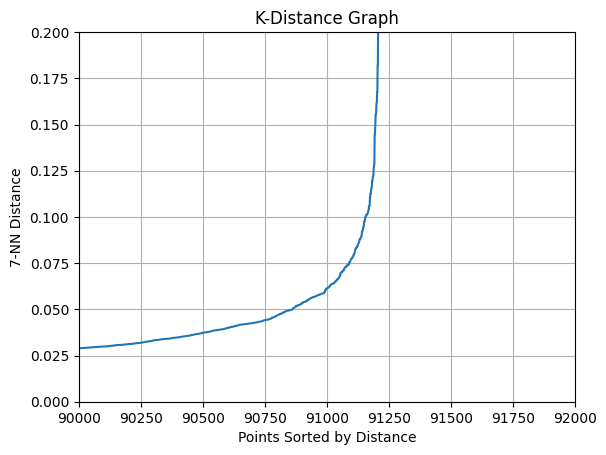

In [272]:
# Compare with DBScan clustering
df_db = df_final.loc[:,['review_score','Monetary','order_item_id','Freight_ratio','time_delivery','payment_installments']]   
scaler = MinMaxScaler()
scaler.fit(df_db)
df_mmsed = scaler.transform(df_db)
knn = NearestNeighbors(n_neighbors = 2)
model = knn.fit(df_mmsed)
distances, indices = knn.kneighbors(df_mmsed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances);
plt.xlabel('Points Sorted by Distance')
plt.ylabel('7-NN Distance')
plt.title('K-Distance Graph');
plt.xlim([90000,92000])
plt.ylim([0, 0.2])

#The optimal value for epsilon will be found at the point of maximum curvature : around 0.06

In [275]:
scaler = MinMaxScaler()
scaler.fit(df_db)
df_mmsed = scaler.transform(df_db)

db=DBSCAN(eps=0.1,min_samples=7,metric='euclidean') #tries with eps = 0.05 to 0.1 with min_samples = nVariables + 1
model=db.fit(df_mmsed)
label=model.labels_

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

#Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters + 1)

df_k = df_db.assign(Cluster = label)

plt.show()

print("Silhouette score for "+str(n_clusters +1)+" clusters is " +str(metrics.silhouette_score(df_k,label,metric="euclidean",random_state=1)))
print("Calinski-Harabasz score for "+ str(n_clusters +1)+" clusters is "
           +str(metrics.calinski_harabasz_score(df_k,label)))
# Best segmentation is 4-5 clusters

No of clusters: 4
Silhouette score for 4 clusters is 0.02516930034278301
Calinski-Harabasz score for 4 clusters is 2293.554472941416


In [290]:
scaler = MinMaxScaler()
scaler.fit(df_db)
df_mmsed = scaler.transform(df_db)

db=DBSCAN(eps=0.06,min_samples=7,metric='euclidean') #tries with eps = 1.4 and 1.5 with min_samples = nVariables + 1
model=db.fit(df_mmsed)
label=model.labels_

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

#Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters + 1)

df_k = df_db.assign(Cluster = label)

plt.show()

print("Silhouette score for "+str(n_clusters +1)+" clusters is " +str(metrics.silhouette_score(df_k,label,metric="euclidean",random_state=1)))
print("Calinski-Harabasz score for "+ str(n_clusters +1)+" clusters is "
           +str(metrics.calinski_harabasz_score(df_k,label)))
# Best segmentation is 4-5 clusters

No of clusters: 9
Silhouette score for 9 clusters is -0.23060772954241787
Calinski-Harabasz score for 9 clusters is 1035.5458792978525


In [278]:
scaler = MinMaxScaler()
scaler.fit(df_db)
df_mmsed = scaler.transform(df_db)

db=DBSCAN(eps=0.065,min_samples=7,metric='euclidean') #tries with eps = 1.4 and 1.5 with min_samples = nVariables + 1
model=db.fit(df_mmsed)
label=model.labels_

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

#Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters + 1)

df_k = df_db.assign(Cluster = label)

plt.show()

print("Silhouette score for "+str(n_clusters +1)+" clusters is " +str(metrics.silhouette_score(df_k,label,metric="euclidean",random_state=1)))
print("Calinski-Harabasz score for "+ str(n_clusters +1)+" clusters is "
           +str(metrics.calinski_harabasz_score(df_k,label)))
# Best segmentation is 4-5 clusters

No of clusters: 6
Silhouette score for 6 clusters is 0.0319478038921697
Calinski-Harabasz score for 6 clusters is 1691.4678704734808


In [ ]:
#Segmentation with DBScan is not satisfying, Silhouette and Calinski score are very low.

# Hierarchical clustering <a class="anchor" id='section_1_4' ></a>

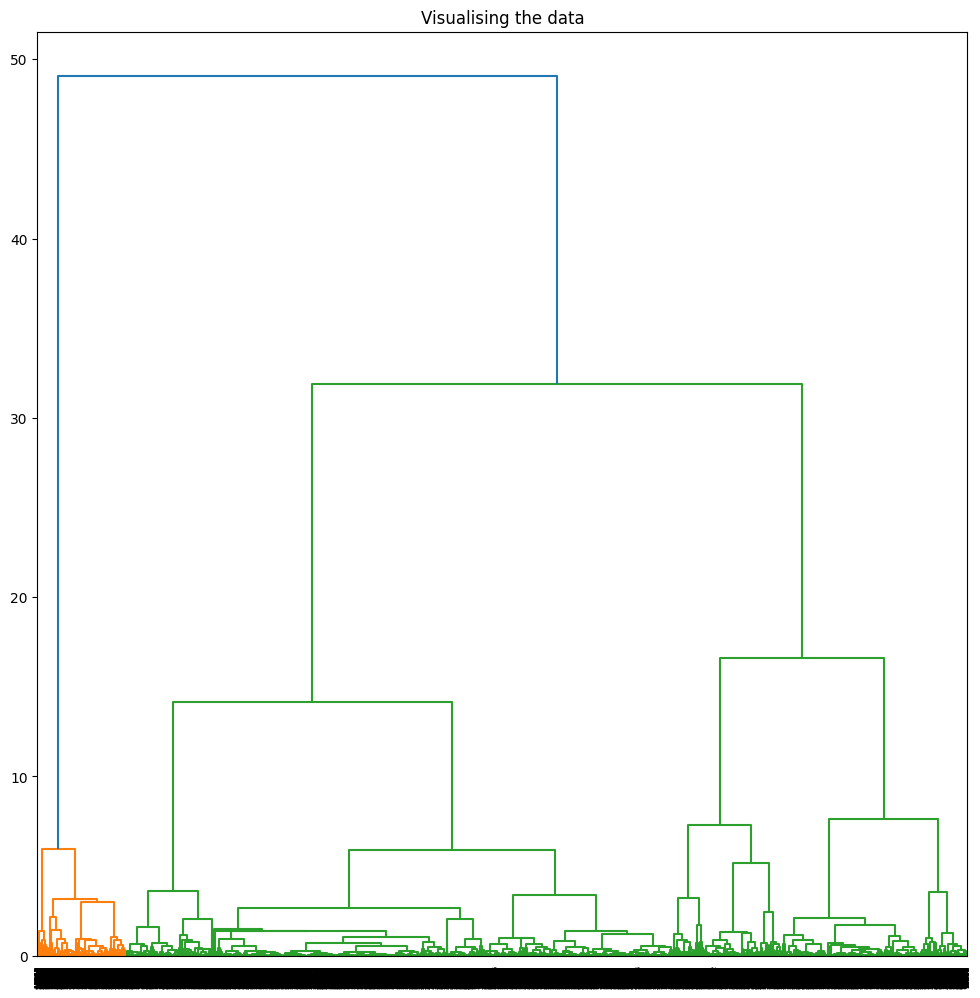

In [279]:
#Hierarchical clustering with partition
X_train, X_test,  = train_test_split(df_mmsed, test_size=0.8, random_state=0)

# Dendograms are used to divide a given cluster into many different clusters.

# Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))


In [291]:
#Find silhouette score for hierachical clustering

df_mmsed = pd.DataFrame(df_mmsed) #necessary to change to df from array for the method

y_train, y_test,  = train_test_split(df_mmsed, test_size=0.2, random_state=0)

for i in range(2,9):
    ac = AgglomerativeClustering(n_clusters = i)
    ac.fit_predict(y_test)
    print("Silhouette score for "+ str(i)+" clusters is " + str(metrics.silhouette_score(y_test, ac.fit_predict(y_test))))
    print("Calinski-Harabasz score for "+ str(i)+" clusters is "
           +str(metrics.calinski_harabasz_score(y_test, ac.fit_predict(y_test))))

Silhouette score for 2 clusters is 0.6667602808564552
Calinski-Harabasz score for 2 clusters is 23321.073925170145
Silhouette score for 3 clusters is 0.5663734836086644
Calinski-Harabasz score for 3 clusters is 35558.65298060504
Silhouette score for 4 clusters is 0.5306836077699202
Calinski-Harabasz score for 4 clusters is 33545.500478269925
Silhouette score for 5 clusters is 0.5568056205350159
Calinski-Harabasz score for 5 clusters is 37741.255633113164
Silhouette score for 6 clusters is 0.5810259896823434
Calinski-Harabasz score for 6 clusters is 39643.72413760425
Silhouette score for 7 clusters is 0.5809159384970736
Calinski-Harabasz score for 7 clusters is 37813.66351436058
Silhouette score for 8 clusters is 0.5110540222044072
Calinski-Harabasz score for 8 clusters is 36955.231484077674


In [ ]:
# With Hierarchical clustering, Silhouette-Calinsky score are better than DBScan but still worst than Kmeans.
# Moreover its is not recommended to perform hierarchical clustering on large datatset as it requires lots of computation power.
# Thus, Kmeans seems to be the best option for clustering in this project.

# Results <a class="anchor" id='chapter3'></a>

In [ ]:
# Thus the segmentation can be done with 4 or 5 clusters using Kmeans. 

# To mitigate this choice we will use 4 but depending on more insights from the marketing team, 
# we could chose differently.

# We can then identify 4 types:

# Group 1: Very satisfied customer with an average wallet who ordered nearly 1 item per order, whose delivery time is short and who requires little of payment installments.
# Group 2: Very dissatisfied customer with a large wallet who ordered 1 or more items per order, whose delivery time is long and who uses several payment installments.
# Group 3: Moderately satisfied customer with an average wallet who ordered nearly 1 item per order, whose delivery time is quite short and who uses several payment installments.
# Group 4: Very satisfied customer, very large wallet who ordered nearly 1 item per order, whose delivery time is quite short, whose transport payment ratio is low and who uses a lot of payment installments.